# Import libraries

In [199]:
# Data analysis and wragling
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt 
import missingno

# Statistics
from statistics import stdev
from scipy.stats import t

# Dates
import matplotlib.dates as mdates

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Load data

In [200]:
data = pd.read_csv('/home/ayodeji/Downloads/Documents/QUANTIUM/QVI_data.csv')
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [201]:
data.shape

(264834, 12)

<AxesSubplot:>

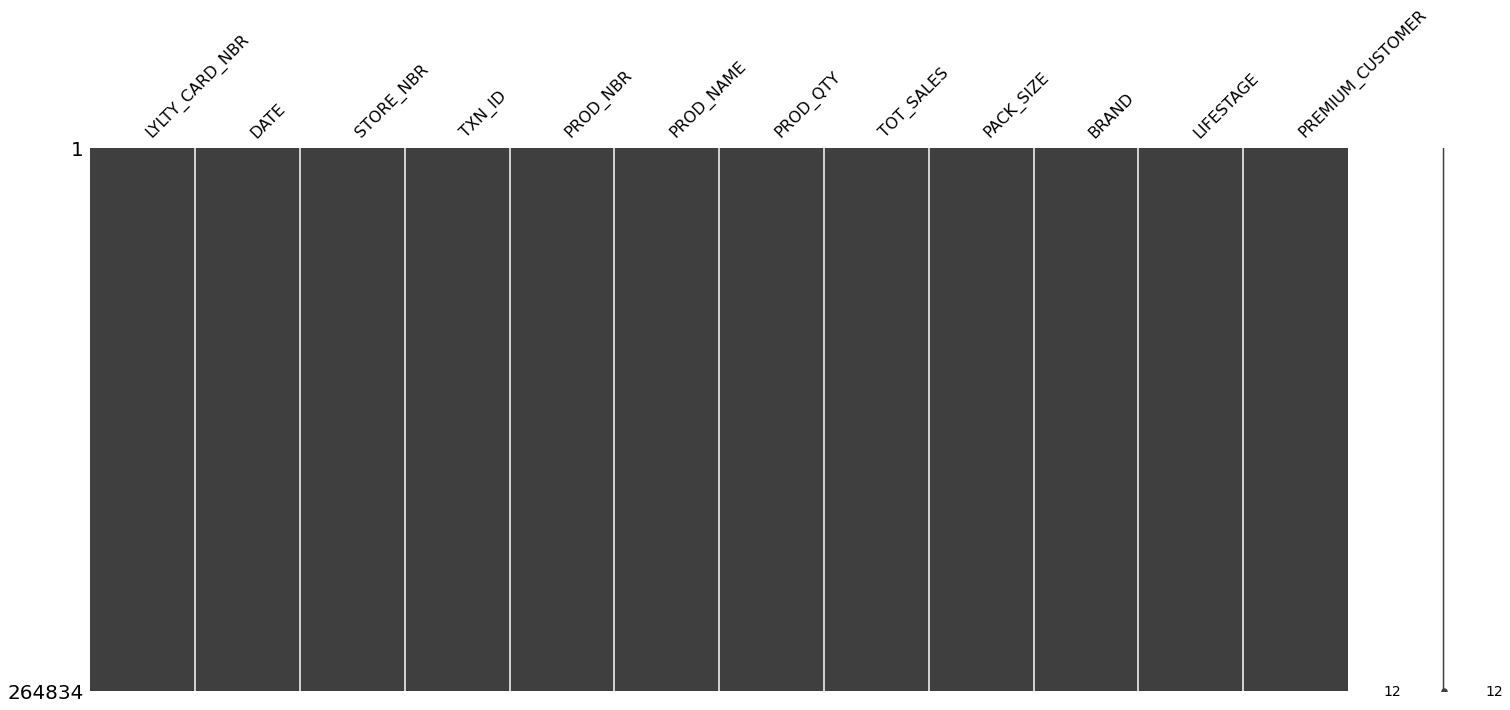

In [202]:
# Check for null 

missingno.matrix(data)

# Select control stores

The client has selected stores 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period.

We would want to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of:

- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

Let's first create the metrics of interest and filter out stores that are present throughout the pre-trial period.

In [203]:
# Create 'YEARMONTH' feature

data['YEARMONTH'] = [''.join(x.split('-')[0:2]) for x in data.DATE]
data['YEARMONTH'] = pd.to_numeric(data['YEARMONTH'])
data['YEARMONTH'].head()

0    201810
1    201809
2    201903
3    201903
4    201811
Name: YEARMONTH, dtype: int64

In [204]:
# Check to see if 'YEARMONTH' is 'int'

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
 12  YEARMONTH         264834 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 26.3+ MB


For each month and store, calculate:

1. Total sales
2. Number of customers
3. Transaction per customer
4. Chips per transaction
5. Average price per unit

Create individual dataframe and then concatenate all of them together at the end.

In [205]:
# Monthly store total sales
# Sum up total sales

totSales = data.groupby(['STORE_NBR', 'YEARMONTH']).TOT_SALES.sum()
totSales

STORE_NBR  YEARMONTH
1          201807       206.9
           201808       176.1
           201809       278.8
           201810       188.1
           201811       192.6
                        ...  
272        201902       395.5
           201903       442.3
           201904       445.1
           201905       314.6
           201906       312.1
Name: TOT_SALES, Length: 3169, dtype: float64

In [206]:
# Monthly store number of customers
# Count the unique loyalty card number for each store in each month

nCustomers = data.groupby(['STORE_NBR', 'YEARMONTH']).LYLTY_CARD_NBR.nunique()
nCustomers

STORE_NBR  YEARMONTH
1          201807       49
           201808       42
           201809       59
           201810       44
           201811       46
                        ..
272        201902       45
           201903       50
           201904       54
           201905       34
           201906       34
Name: LYLTY_CARD_NBR, Length: 3169, dtype: int64

In [207]:
# Monthly store number of transactions per customer
# Divided unique transaction ID by unique loyalty card number

nTxnPerCust = data.groupby(['STORE_NBR', 'YEARMONTH']).TXN_ID.nunique() / data.groupby(['STORE_NBR', 'YEARMONTH']).LYLTY_CARD_NBR.nunique()
nTxnPerCust

STORE_NBR  YEARMONTH
1          201807       1.061224
           201808       1.023810
           201809       1.050847
           201810       1.022727
           201811       1.021739
                          ...   
272        201902       1.066667
           201903       1.060000
           201904       1.018519
           201905       1.176471
           201906       1.088235
Length: 3169, dtype: float64

In [208]:
# Monthly store number of chips per transaction
# Sum up product quantity and divided that by number of unique transactions

nChipsPerTxn = data.groupby(['STORE_NBR', 'YEARMONTH']).PROD_QTY.sum() / data.groupby(['STORE_NBR', 'YEARMONTH']).TXN_ID.nunique()
nChipsPerTxn

STORE_NBR  YEARMONTH
1          201807       1.192308
           201808       1.255814
           201809       1.209677
           201810       1.288889
           201811       1.212766
                          ...   
272        201902       1.895833
           201903       1.905660
           201904       1.909091
           201905       1.775000
           201906       1.891892
Length: 3169, dtype: float64

In [209]:
# Monthly store average price per unit
# Sum up total sales and divide that by sum of product quantity

avgPricePerUnit = data.groupby(['STORE_NBR', 'YEARMONTH']).TOT_SALES.sum() / data.groupby(['STORE_NBR', 'YEARMONTH']).PROD_QTY.sum()
avgPricePerUnit

STORE_NBR  YEARMONTH
1          201807       3.337097
           201808       3.261111
           201809       3.717333
           201810       3.243103
           201811       3.378947
                          ...   
272        201902       4.346154
           201903       4.379208
           201904       4.239048
           201905       4.430986
           201906       4.458571
Length: 3169, dtype: float64

In [210]:
# Concatenate into a new dataframe called 'measureOverTime'

df = [totSales, nCustomers, nTxnPerCust, nChipsPerTxn, avgPricePerUnit]
measureOverTime = pd.concat(df, join = 'outer', axis = 1)
measureOverTime

TOT_SALES  LYLTY_CARD_NBR         0         1         2
STORE_NBR YEARMONTH                                                         
1         201807         206.9              49  1.061224  1.192308  3.337097
          201808         176.1              42  1.023810  1.255814  3.261111
          201809         278.8              59  1.050847  1.209677  3.717333
          201810         188.1              44  1.022727  1.288889  3.243103
          201811         192.6              46  1.021739  1.212766  3.378947
...                        ...             ...       ...       ...       ...
272       201902         395.5              45  1.066667  1.895833  4.346154
          201903         442.3              50  1.060000  1.905660  4.379208
          201904         445.1              54  1.018519  1.909091  4.239048
          201905         314.6              34  1.176471  1.775000  4.430986
          201906         312.1              34  1.088235  1.891892  4.458571

[3169 rows x 5 columns]

In [211]:
# Rename the columns

measureOverTime.rename(columns = {'TOT_SALES': 'totSales', 'LYLTY_CARD_NBR': 'nCustomers', 0: 'nChipsPerCust', 1: 'nChipsPerTxn', 2: 'avgPricePerUnit'}, inplace = True)
measureOverTime.head()

totSales  nCustomers  nChipsPerCust  nChipsPerTxn  \
STORE_NBR YEARMONTH                                                      
1         201807        206.9          49       1.061224      1.192308   
          201808        176.1          42       1.023810      1.255814   
          201809        278.8          59       1.050847      1.209677   
          201810        188.1          44       1.022727      1.288889   
          201811        192.6          46       1.021739      1.212766   

                     avgPricePerUnit  
STORE_NBR YEARMONTH                   
1         201807            3.337097  
          201808            3.261111  
          201809            3.717333  
          201810            3.243103  
          201811            3.378947

In [212]:
# Which stores do not have full observation i.e. have months where there is no transaction for chips

a = pd.pivot_table(data, index = 'STORE_NBR', columns = 'YEARMONTH', values = 'TXN_ID', aggfunc = 'count')
a

YEARMONTH,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906
STORE_NBR,,,,,,,,,,,,
1,52.0,43.0,62.0,45.0,47.0,47.0,36.0,55.0,49.0,43.0,51.0,43.0
2,41.0,43.0,37.0,43.0,40.0,38.0,45.0,32.0,46.0,49.0,50.0,42.0
3,138.0,134.0,119.0,119.0,118.0,129.0,121.0,139.0,130.0,110.0,123.0,122.0
4,160.0,151.0,138.0,155.0,139.0,133.0,168.0,102.0,135.0,137.0,126.0,134.0
5,120.0,112.0,125.0,107.0,111.0,125.0,118.0,106.0,97.0,109.0,104.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...
268,52.0,54.0,34.0,48.0,51.0,43.0,38.0,37.0,47.0,50.0,52.0,40.0
269,139.0,132.0,124.0,148.0,136.0,133.0,144.0,133.0,122.0,139.0,130.0,127.0
270,139.0,154.0,126.0,119.0,133.0,149.0,155.0,125.0,143.0,132.0,128.0,127.0


In [213]:
a.isnull().sum()

YEARMONTH
201807    6
201808    9
201809    8
201810    7
201811    8
201812    9
201901    9
201902    8
201903    7
201904    7
201905    9
201906    8
dtype: int64

<AxesSubplot:>

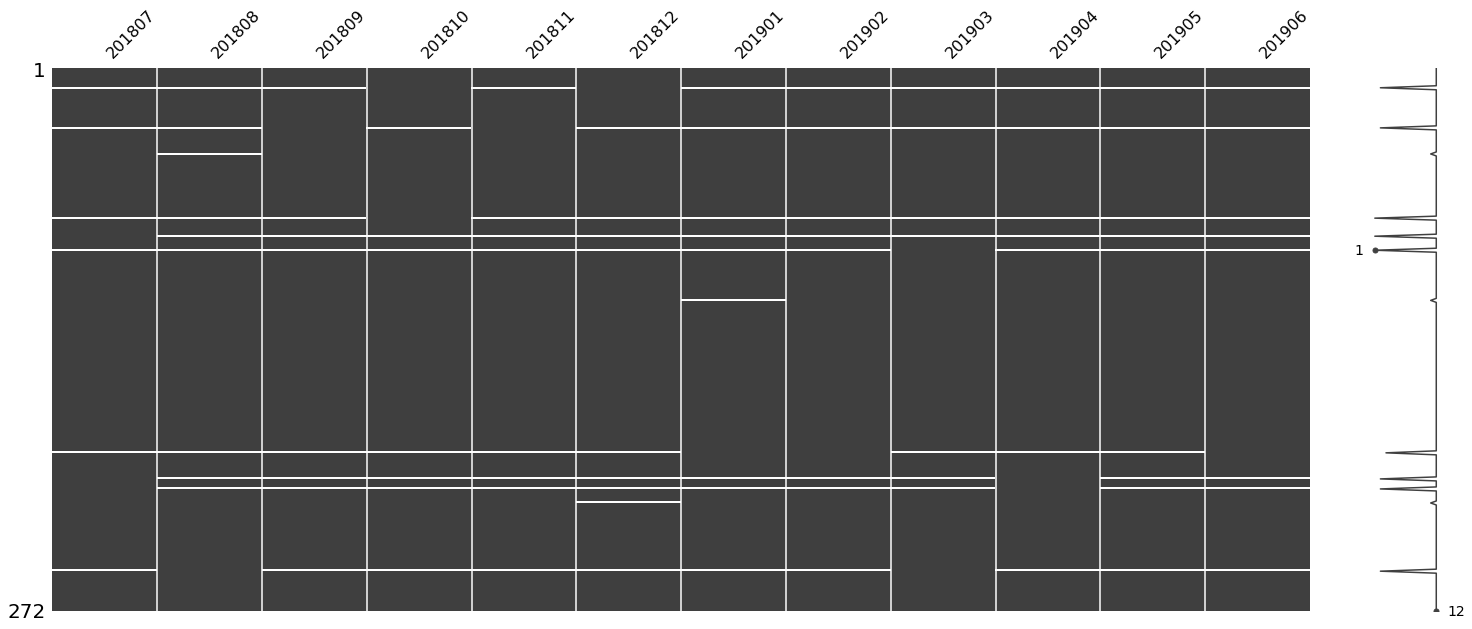

In [214]:
# Let's visualise the null values

missingno.matrix(a)

In [215]:
# Store numbers that do not have full observation periods

null_store = a[a.isnull().any(axis=1)].index.tolist()
null_store

[11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]

In [216]:
len(null_store)

# Comment: There are 12 stores with incomplete observation period

12

In [217]:
# Let's drop these stores from 'measureOverTime'

measureOverTime.head()

totSales  nCustomers  nChipsPerCust  nChipsPerTxn  \
STORE_NBR YEARMONTH                                                      
1         201807        206.9          49       1.061224      1.192308   
          201808        176.1          42       1.023810      1.255814   
          201809        278.8          59       1.050847      1.209677   
          201810        188.1          44       1.022727      1.288889   
          201811        192.6          46       1.021739      1.212766   

                     avgPricePerUnit  
STORE_NBR YEARMONTH                   
1         201807            3.337097  
          201808            3.261111  
          201809            3.717333  
          201810            3.243103  
          201811            3.378947

In [218]:
len(measureOverTime)

3169

In [219]:
measureOverTime.reset_index(inplace = True)
measureOverTime.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947


In [220]:
# Drop 'null_store' from 'measureOverTime' dataframe

measureOverTime = measureOverTime[~measureOverTime['STORE_NBR'].isin(null_store)]
len(measureOverTime)

3120

In [221]:
# Create new dataframe 'preTrialMeasures' 
# Filter to pre-trial period i.e. before 201902

preTrialMeasures = measureOverTime.loc[measureOverTime['YEARMONTH'] < 201902, :]
len(preTrialMeasures)

1820

In [222]:
preTrialMeasures.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947


In [223]:
# Create a function which calculates the correlation between trial store and other stores based on a single metric

def calculateCorrelation(inputTable, metric, trial_store):
    output = pd.DataFrame({'Store1': [], 'Store2': [], 'Correlation': []})
    a = inputTable.loc[inputTable['STORE_NBR'] == trial_store, metric]
    a.reset_index(drop = True, inplace = True)
    storeNumbers = inputTable['STORE_NBR'].unique()
    for i in storeNumbers:
        b = inputTable.loc[inputTable['STORE_NBR'] == i, metric]
        b.reset_index(drop = True, inplace = True)
        output = output.append({'Store1': trial_store, 'Store2': i, 'Correlation': b.corr(a)}, ignore_index = True)
    return output

In [224]:
# Create another function which calculates a standardised magnitude difference 

def calculateMagnitudeDistance(inputTable, metric, trial_store):
    output = pd.DataFrame({'Store1': [], 'Store2': [], 'Magnitude' : []})
    a = inputTable.loc[inputTable['STORE_NBR'] == trial_store, metric]
    a.reset_index(drop = True, inplace = True)
    storeNumbers = inputTable['STORE_NBR'].unique()
    for i in storeNumbers:
        b = inputTable.loc[inputTable['STORE_NBR'] == i, metric]
        b.reset_index(drop = True, inplace = True)
        c = abs(a-b)
        d = np.mean(1-(c-min(c))/(max(c)-min(c)))
        output = output.append({'Store1': trial_store, 'Store2': i, 'Magnitude': d}, ignore_index = True)
    return output

# Selecting control store for trial store 77

In [225]:
# Now let's use those two functions to find the control store

# Compute correlation with trial store 77
trial_store = 77
corr_nSales = calculateCorrelation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculateCorrelation(preTrialMeasures, 'nCustomers', trial_store)

# Compute magnitude with trial store 77
magnitude_nSales = calculateMagnitudeDistance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(preTrialMeasures, 'nCustomers', trial_store)


In [226]:
# Let's see what they look like

corr_nSales.head()

,Store1,Store2,Correlation
0,77.0,1.0,0.075218
1,77.0,2.0,-0.263079
2,77.0,3.0,0.806644
3,77.0,4.0,-0.263300
4,77.0,5.0,-0.110652


In [227]:
magnitude_nSales.head()

,Store1,Store2,Magnitude
0,77.0,1.0,0.408163
1,77.0,2.0,0.590119
2,77.0,3.0,0.522914
3,77.0,4.0,0.644934
4,77.0,5.0,0.516320


In [228]:
# Concatenate the scores together for 'nSales'

score_nSales = pd.concat([corr_nSales, magnitude_nSales['Magnitude']], axis = 1)

In [229]:
# Add an additional column which calculates the weighted average

corr_weight = 0.5

score_nSales['scoreNSales'] = corr_weight * score_nSales['Correlation'] + (1 - corr_weight) * score_nSales['Magnitude']
score_nSales.head()

,Store1,Store2,Correlation,Magnitude,scoreNSales
0,77.0,1.0,0.075218,0.408163,0.241691
1,77.0,2.0,-0.263079,0.590119,0.163520
2,77.0,3.0,0.806644,0.522914,0.664779
3,77.0,4.0,-0.263300,0.644934,0.190817
4,77.0,5.0,-0.110652,0.516320,0.202834


In [230]:
# Now do the same for 'nCustomers'

score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['Magnitude']], axis = 1)
score_nCustomers.head()

,Store1,Store2,Correlation,Magnitude
0,77.0,1.0,0.322168,0.663866
1,77.0,2.0,-0.572051,0.471429
2,77.0,3.0,0.834207,0.489796
3,77.0,4.0,-0.295639,0.498258
4,77.0,5.0,0.370659,0.512605


In [231]:
# Again add a new column for weighted average

score_nCustomers['scoreNCust'] = corr_weight * score_nCustomers['Correlation'] + (1 - corr_weight) * score_nCustomers['Magnitude']
score_nCustomers.head()

,Store1,Store2,Correlation,Magnitude,scoreNCust
0,77.0,1.0,0.322168,0.663866,0.493017
1,77.0,2.0,-0.572051,0.471429,-0.050311
2,77.0,3.0,0.834207,0.489796,0.662002
3,77.0,4.0,-0.295639,0.498258,0.101310
4,77.0,5.0,0.370659,0.512605,0.441632


In [232]:
# Index both 'score_nSales' and 'score_nCustomers' dataframe

score_nSales.set_index(['Store1', 'Store2'], inplace = True)
score_nCustomers.set_index(['Store1', 'Store2'], inplace = True)

In [233]:
# Create a new dataframe 'score_Control' which takes the average of 'scoreNSales' and 'scoreNCust'

score_Control = pd.concat([score_nSales['scoreNSales'], score_nCustomers['scoreNCust']], axis = 1)
score_Control

scoreNSales  scoreNCust
Store1 Store2                         
77.0   1.0        0.241691    0.493017
       2.0        0.163520   -0.050311
       3.0        0.664779    0.662002
       4.0        0.190817    0.101310
       5.0        0.202834    0.441632
...                    ...         ...
       268.0      0.387272    0.470473
       269.0      0.121684    0.005090
       270.0      0.453489    0.202710
       271.0      0.348289    0.174100
       272.0      0.320626    0.384336

[260 rows x 2 columns]

In [234]:
# Add a new column to 'score_Control' which computes the average of 'scoreNSales' and 'scoreNCust'

score_Control['finalControlScore'] = 0.5 * (score_Control['scoreNSales'] + score_Control['scoreNCust'])
score_Control.head()

scoreNSales  scoreNCust  finalControlScore
Store1 Store2                                            
77.0   1.0        0.241691    0.493017           0.367354
       2.0        0.163520   -0.050311           0.056604
       3.0        0.664779    0.662002           0.663390
       4.0        0.190817    0.101310           0.146064
       5.0        0.202834    0.441632           0.322233

In [235]:
# Let's see the top 5 stores with highest 'finalControlScore'

score_Control.sort_values(by = 'finalControlScore', ascending = False).head()

# Comment: store 233 matches trial store 77 the most 

scoreNSales  scoreNCust  finalControlScore
Store1 Store2                                            
77.0   233.0      0.697290    0.816607           0.756949
       71.0       0.789497    0.663123           0.726310
       84.0       0.656972    0.715000           0.685986
       119.0      0.636046    0.729729           0.682887
       115.0      0.708347    0.645155           0.676751

In [236]:
# Now that we have found a control store, let's check visually if the drivers are indeed similar to store 77 before the trial period
# Set store 233 as 'control_store'

control_store = 233

In [237]:
# Create a new dataframe 'pastSales'
pastSales = preTrialMeasures

# Create a new column within 'pastSales' which categorises store type
store_type = []

for i in pastSales['STORE_NBR']:
    if i == trial_store:
        store_type.append('Trial Store')
    elif i == control_store:
        store_type.append('Control Store')
    else:
        store_type.append('Other Stores')

pastSales['store_type'] = store_type
pastSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores


In [238]:
# Check the unique values under 'store_type' column

pastSales['store_type'].unique()

array(['Other Stores', 'Trial Store', 'Control Store'], dtype=object)

In [239]:
pastSales.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1820 entries, 0 to 3163
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STORE_NBR        1820 non-null   int64  
 1   YEARMONTH        1820 non-null   int64  
 2   totSales         1820 non-null   float64
 3   nCustomers       1820 non-null   int64  
 4   nChipsPerCust    1820 non-null   float64
 5   nChipsPerTxn     1820 non-null   float64
 6   avgPricePerUnit  1820 non-null   float64
 7   store_type       1820 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 128.0+ KB


In [240]:
# Currently 'YEARMONTH' is an int64 so we need to turn it into a datetime variable to able to plot
# Create a new column 'TransactionMonth'

pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format = '%Y%m')
pastSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


In [241]:
# Now create 'totSales' visualisation for control store, trial store and other stores

# First create relevant dataframes 
controlSalesPlot = pastSales.loc[pastSales['store_type'] == 'Control Store', ['TransactionMonth', 'totSales']]
controlSalesPlot.set_index('TransactionMonth', inplace = True)
controlSalesPlot.rename(columns = {'totSales': 'Control Store'}, inplace = True)
trialSalesPlot = pastSales.loc[pastSales['store_type'] == 'Trial Store', ['TransactionMonth', 'totSales']]
trialSalesPlot.set_index('TransactionMonth', inplace = True)
trialSalesPlot.rename(columns = {'totSales': 'Trial Store'}, inplace = True)
otherSalesPlot = pastSales.loc[pastSales['store_type'] == 'Other Stores', ['TransactionMonth', 'totSales']]
otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('TransactionMonth').totSales.mean())
otherSalesPlot.rename(columns = {'totSales': 'Other Stores'}, inplace = True)

# Concatenate
combineSalesPlot = pd.concat([controlSalesPlot, trialSalesPlot, otherSalesPlot], axis = 1)
combineSalesPlot

,Control Store,Trial Store,Other Stores
TransactionMonth,,,
2018-07-01,290.7,296.8,638.004651
2018-08-01,285.9,255.5,610.223450
2018-09-01,228.6,225.2,620.198450
2018-10-01,185.7,204.5,635.314729
2018-11-01,211.6,245.3,618.864341
2018-12-01,279.8,267.3,648.453876
2019-01-01,177.5,204.4,628.684496


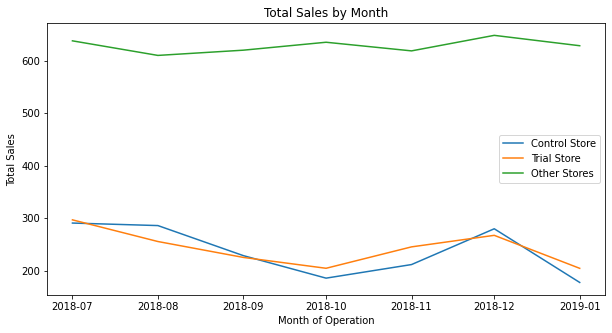

In [242]:
# Plot total sales by month for all 3 types of stores

plt.figure(figsize = (10, 5))
plt.plot(combineSalesPlot)
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 5)

In [243]:
# Do the same for 'nCustomers' 

# First create relevant dataframes 
controlCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Control Store', ['TransactionMonth', 'nCustomers']]
controlCustomersPlot.set_index('TransactionMonth', inplace = True)
controlCustomersPlot.rename(columns = {'nCustomers': 'Control Store'}, inplace = True)
trialCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Trial Store', ['TransactionMonth', 'nCustomers']]
trialCustomersPlot.set_index('TransactionMonth', inplace = True)
trialCustomersPlot.rename(columns = {'nCustomers': 'Trial Store'}, inplace = True)
otherCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Other Stores', ['TransactionMonth', 'nCustomers']]
otherCustomersPlot = pd.DataFrame(otherCustomersPlot.groupby('TransactionMonth').nCustomers.mean())
otherCustomersPlot.rename(columns = {'nCustomers': 'Other Stores'}, inplace = True)

# Concatenate
combineCustomersPlot = pd.concat([controlCustomersPlot, trialCustomersPlot, otherCustomersPlot], axis = 1)
combineCustomersPlot

,Control Store,Trial Store,Other Stores
TransactionMonth,,,
2018-07-01,51,51,72.333333
2018-08-01,48,47,72.120155
2018-09-01,42,42,70.131783
2018-10-01,35,37,71.608527
2018-11-01,40,41,70.534884
2018-12-01,47,46,73.515504
2019-01-01,35,35,71.240310


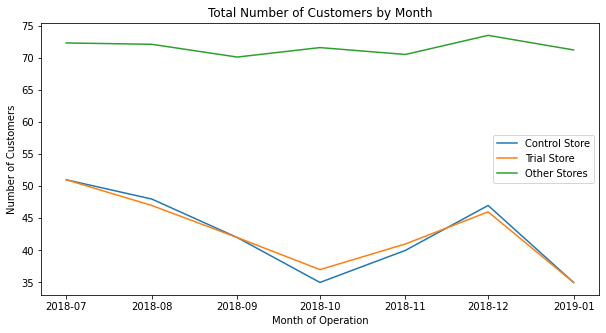

In [244]:
# Plot total number of customers for all 3 types of stores

plt.figure(figsize = (10, 5))
plt.plot(combineCustomersPlot)
plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 5)

# Assessment of trial for trial strore 77

The trial period goes from the start of February 2019 to end of April 2019. I now want to see if there has been an uplift in overall chip sales. 

In [245]:
preTrialMeasures.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


In [246]:
# First I work out a scaling factor to applied to the control store
# I compute this by dividing sum of 'totSales' for trial store by sum of 'totSales' for control store
# Calling this variable 'scalingFactorSales'

trial_sum = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Trial Store' , 'totSales'].sum()
control_sum = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Control Store', 'totSales'].sum()
scalingFactorSales = trial_sum / control_sum
scalingFactorSales

1.023617303289553

In [247]:
# Create a new dataframe 'scaledControlSales'
# Recall our dataframe before filtering out the trial period is called 'measureOverTime'

measureOverTime.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947


In [248]:
# Create dataframe and reset index

scaledControlSales = measureOverTime
scaledControlSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947


In [249]:
# We only want control store i.e. store 233

scaledControlSales = scaledControlSales.loc[scaledControlSales['STORE_NBR'] == control_store]
scaledControlSales

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit
2699,233,201807,290.7,51,1.058824,1.629630,3.303409
2700,233,201808,285.9,48,1.041667,1.600000,3.573750
2701,233,201809,228.6,42,1.071429,1.555556,3.265714
2702,233,201810,185.7,35,1.028571,1.555556,3.316071
2703,233,201811,211.6,40,1.025000,1.512195,3.412903
2704,233,201812,279.8,47,1.063830,1.500000,3.730667
2705,233,201901,177.5,35,1.000000,1.342857,3.776596
2706,233,201902,244.0,45,1.044444,1.489362,3.485714
2707,233,201903,199.1,40,1.025000,1.439024,3.374576
2708,233,201904,158.6,30,1.066667,1.437500,3.447826


In [250]:
# Create 'controlSales' which applies 'scalingFactorSales' to 'totSales' column

scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorSales
scaledControlSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,controlSales
2699,233,201807,290.7,51,1.058824,1.629630,3.303409,297.565550
2700,233,201808,285.9,48,1.041667,1.600000,3.573750,292.652187
2701,233,201809,228.6,42,1.071429,1.555556,3.265714,233.998916
2702,233,201810,185.7,35,1.028571,1.555556,3.316071,190.085733
2703,233,201811,211.6,40,1.025000,1.512195,3.412903,216.597421


In [251]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlSales[['YEARMONTH', 'controlSales']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'totSales'
trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, 'totSales']
trialSales.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialSales], axis = 1)
percentageDiff.rename(columns = {'totSales': 'trialSales'}, inplace = True)

percentageDiff

,YEARMONTH,controlSales,trialSales
0,201807,297.565550,296.8
1,201808,292.652187,255.5
2,201809,233.998916,225.2
3,201810,190.085733,204.5
4,201811,216.597421,245.3
5,201812,286.408121,267.3
6,201901,181.692071,204.4
7,201902,249.762622,235.0
8,201903,203.802205,278.5
9,201904,162.345704,263.5


In [252]:
# Calculate percentage difference and put it in a new column

percentageDiff['percentageDiff'] = abs(percentageDiff.controlSales - percentageDiff.trialSales) / percentageDiff.controlSales
percentageDiff

,YEARMONTH,controlSales,trialSales,percentageDiff
0,201807,297.565550,296.8,0.002573
1,201808,292.652187,255.5,0.126950
2,201809,233.998916,225.2,0.037602
3,201810,190.085733,204.5,0.075830
4,201811,216.597421,245.3,0.132516
5,201812,286.408121,267.3,0.066716
6,201901,181.692071,204.4,0.124980
7,201902,249.762622,235.0,0.059107
8,201903,203.802205,278.5,0.366521
9,201904,162.345704,263.5,0.623080


In [253]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = stdev(percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'])
stdDev

0.04994076264142537

In [254]:
# Define the degrees of freedom
# Since we have 8 pre-trial months, dof = 8 - 1 = 7

dof = 7

In [255]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905), 'tValue']

7     1.183534
8     7.339116
9    12.476373
Name: tValue, dtype: float64

In [256]:
# Find the 95th percentile of the t distribution with dof = 7

t.isf(0.05, dof)

# Comment: We can see that the t-value is much larger than the 95th percentile value of the t-distribution for March and April

1.8945786050613054

In [257]:
# Recall our 'scaledControlSales' dataframe

scaledControlSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,controlSales
2699,233,201807,290.7,51,1.058824,1.629630,3.303409,297.565550
2700,233,201808,285.9,48,1.041667,1.600000,3.573750,292.652187
2701,233,201809,228.6,42,1.071429,1.555556,3.265714,233.998916
2702,233,201810,185.7,35,1.028571,1.555556,3.316071,190.085733
2703,233,201811,211.6,40,1.025000,1.512195,3.412903,216.597421


In [258]:
# Add a new column 'TransactionMonth' to 'scaledControlSales'

scaledControlSales['TransactionMonth'] = pd.to_datetime(scaledControlSales['YEARMONTH'].astype(str), format = '%Y%m')
scaledControlSales

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,controlSales,TransactionMonth
2699,233,201807,290.7,51,1.058824,1.629630,3.303409,297.565550,2018-07-01
2700,233,201808,285.9,48,1.041667,1.600000,3.573750,292.652187,2018-08-01
2701,233,201809,228.6,42,1.071429,1.555556,3.265714,233.998916,2018-09-01
2702,233,201810,185.7,35,1.028571,1.555556,3.316071,190.085733,2018-10-01
2703,233,201811,211.6,40,1.025000,1.512195,3.412903,216.597421,2018-11-01
2704,233,201812,279.8,47,1.063830,1.500000,3.730667,286.408121,2018-12-01
2705,233,201901,177.5,35,1.000000,1.342857,3.776596,181.692071,2019-01-01
2706,233,201902,244.0,45,1.044444,1.489362,3.485714,249.762622,2019-02-01
2707,233,201903,199.1,40,1.025000,1.439024,3.374576,203.802205,2019-03-01
2708,233,201904,158.6,30,1.066667,1.437500,3.447826,162.345704,2019-04-01


In [259]:
# Time for some visualisation
# First we need to create the appropriate dataframe
# Extract 'controlSales' from 'scaledControlSales' dataframe for control store 

controlSales = scaledControlSales.loc[:, ['TransactionMonth', 'controlSales']]
controlSales.set_index('TransactionMonth', inplace = True)
controlSales.rename(columns = {'controlSales': 'Control Sales'}, inplace = True)
controlSales

,Control Sales
TransactionMonth,
2018-07-01,297.565550
2018-08-01,292.652187
2018-09-01,233.998916
2018-10-01,190.085733
2018-11-01,216.597421
2018-12-01,286.408121
2019-01-01,181.692071
2019-02-01,249.762622
2019-03-01,203.802205


In [260]:
# Recall 'measureOverTime' dataframe

measureOverTime.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947


In [261]:
# Create a new column 'TransationMonth' under 'measureOverTime' dataframe

measureOverTime['TransactionMonth'] = pd.to_datetime(measureOverTime['YEARMONTH'].astype(str), format = '%Y%m')
measureOverTime.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,2018-11-01


In [262]:
# Extract 'totSales' for trial store from 'measureOverTime'

trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, ['TransactionMonth', 'totSales']]
trialSales.set_index('TransactionMonth', inplace = True)
trialSales.rename(columns = {'totSales': 'Trial Sales'}, inplace = True)
trialSales

,Trial Sales
TransactionMonth,
2018-07-01,296.8
2018-08-01,255.5
2018-09-01,225.2
2018-10-01,204.5
2018-11-01,245.3
2018-12-01,267.3
2019-01-01,204.4
2019-02-01,235.0
2019-03-01,278.5


In [263]:
# Create two new columns under 'controlSales' which calculates the 5% and 95% confidence interval

controlSales['Control 5% Confidence Interval'] = controlSales['Control Sales'] * (1 - stdDev*2)
controlSales['Control 95% Confidence Interval'] = controlSales['Control Sales'] * (1 + stdDev*2)
controlSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval
TransactionMonth,,,
2018-07-01,297.565550,267.844249,327.286851
2018-08-01,292.652187,263.421640,321.882734
2018-09-01,233.998916,210.626747,257.371084
2018-10-01,190.085733,171.099680,209.071786
2018-11-01,216.597421,194.963341,238.231502
2018-12-01,286.408121,257.801241,315.015001
2019-01-01,181.692071,163.544390,199.839753
2019-02-01,249.762622,224.815950,274.709294
2019-03-01,203.802205,183.446130,224.158280


In [264]:
# Merge the two dataframes together 'controlSales' and 'trialSales'

combineSales = pd.merge(controlSales, trialSales, left_index = True, right_index = True)
combineSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Sales
TransactionMonth,,,,
2018-07-01,297.565550,267.844249,327.286851,296.8
2018-08-01,292.652187,263.421640,321.882734,255.5
2018-09-01,233.998916,210.626747,257.371084,225.2
2018-10-01,190.085733,171.099680,209.071786,204.5
2018-11-01,216.597421,194.963341,238.231502,245.3
2018-12-01,286.408121,257.801241,315.015001,267.3
2019-01-01,181.692071,163.544390,199.839753,204.4
2019-02-01,249.762622,224.815950,274.709294,235.0
2019-03-01,203.802205,183.446130,224.158280,278.5


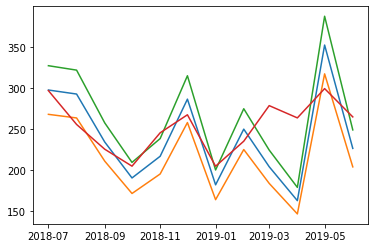

In [265]:
plt.plot(combineSales)

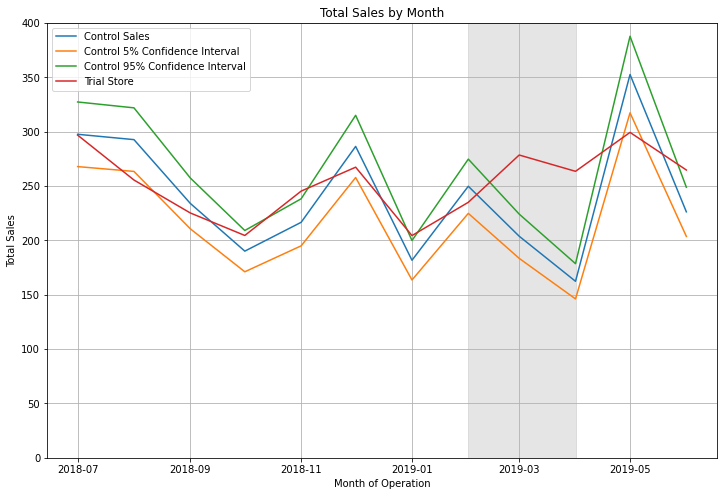

In [266]:
# Let's embellish the plot

# Make it bigger
plt.figure(figsize = (12, 8))
plt.plot(combineSales)

# Set graph title and axis title
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')

# Set legend
plt.legend(['Control Sales', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)

# Set new y-axis limit
plt.ylim((0, 400))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()


The results show that the trial in store 77 is significantly different to its control store in the trial period. The trial store performance lies outside the 5% and 95% confidence intervals in the two of the 3 trial months.

In [267]:
# Now let's move on to 'nCustomers'
# First, compute scaling factor
# Let's call this variable 'scalingFactorCustomers'

trial_customers = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Trial Store' , 'nCustomers'].sum()
control_customers = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Control Store', 'nCustomers'].sum()
scalingFactorCustomers = trial_customers / control_customers
scalingFactorCustomers

1.0033557046979866

In [268]:
scaledControlCustomers = measureOverTime
scaledControlCustomers.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,2018-11-01


In [269]:
scaledControlCustomers = scaledControlCustomers.loc[scaledControlCustomers['STORE_NBR'] == control_store]
scaledControlCustomers.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
2699,233,201807,290.7,51,1.058824,1.629630,3.303409,2018-07-01
2700,233,201808,285.9,48,1.041667,1.600000,3.573750,2018-08-01
2701,233,201809,228.6,42,1.071429,1.555556,3.265714,2018-09-01
2702,233,201810,185.7,35,1.028571,1.555556,3.316071,2018-10-01
2703,233,201811,211.6,40,1.025000,1.512195,3.412903,2018-11-01


In [270]:
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorCustomers
scaledControlCustomers.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlCustomers
2699,233,201807,290.7,51,1.058824,1.629630,3.303409,2018-07-01,51.171141
2700,233,201808,285.9,48,1.041667,1.600000,3.573750,2018-08-01,48.161074
2701,233,201809,228.6,42,1.071429,1.555556,3.265714,2018-09-01,42.140940
2702,233,201810,185.7,35,1.028571,1.555556,3.316071,2018-10-01,35.117450
2703,233,201811,211.6,40,1.025000,1.512195,3.412903,2018-11-01,40.134228


In [271]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlCustomers[['YEARMONTH', 'controlCustomers']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'nCustomers'
trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, 'nCustomers']
trialCustomers.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialCustomers], axis = 1)
percentageDiff.rename(columns = {'nCustomers': 'trialCustomers'}, inplace = True)

percentageDiff

,YEARMONTH,controlCustomers,trialCustomers
0,201807,51.171141,51
1,201808,48.161074,47
2,201809,42.140940,42
3,201810,35.117450,37
4,201811,40.134228,41
5,201812,47.157718,46
6,201901,35.117450,35
7,201902,45.151007,45
8,201903,40.134228,50
9,201904,30.100671,47


In [272]:
# Calculate percentage difference and put it in a new column

percentageDiff['percentageDiff'] = abs(percentageDiff.controlCustomers - percentageDiff.trialCustomers) / percentageDiff.controlCustomers
percentageDiff

,YEARMONTH,controlCustomers,trialCustomers,percentageDiff
0,201807,51.171141,51,0.003344
1,201808,48.161074,47,0.024108
2,201809,42.140940,42,0.003344
3,201810,35.117450,37,0.053607
4,201811,40.134228,41,0.021572
5,201812,47.157718,46,0.024550
6,201901,35.117450,35,0.003344
7,201902,45.151007,45,0.003344
8,201903,40.134228,50,0.245819
9,201904,30.100671,47,0.561427


In [273]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = stdev(percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'])
stdDev

0.018240748558243945

In [274]:
# Define the degrees of freedom
# Since we have 8 pre-trial months, dof = 8 - 1 = 7

dof = 7

In [275]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905), 'tValue']

7     0.183352
8    13.476388
9    30.778725
Name: tValue, dtype: float64

In [276]:
# Find the 95th percentile of the t distribution with dof = 7

t.isf(0.05, dof)

# Comment: We can see that the t-value is much larger than the 95th percentile value of the t-distribution for March and April

1.8945786050613054

In [277]:
# Time for some visualisation
# First we need to create the appropriate dataframe
# Extract 'controlCustomers' from 'scaledControlCustomers' dataframe for control store 

controlCustomers = scaledControlCustomers.loc[:, ['TransactionMonth', 'controlCustomers']]
controlCustomers.set_index('TransactionMonth', inplace = True)
controlCustomers.rename(columns = {'controlCustomers': 'Control Customers'}, inplace = True)
controlCustomers

,Control Customers
TransactionMonth,
2018-07-01,51.171141
2018-08-01,48.161074
2018-09-01,42.140940
2018-10-01,35.117450
2018-11-01,40.134228
2018-12-01,47.157718
2019-01-01,35.117450
2019-02-01,45.151007
2019-03-01,40.134228


In [278]:
# Extract 'nCustomers' for trial store from 'measureOverTime'

trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, ['TransactionMonth', 'nCustomers']]
trialCustomers.set_index('TransactionMonth', inplace = True)
trialCustomers.rename(columns = {'nCustomers': 'Trial Customers'}, inplace = True)
trialCustomers

,Trial Customers
TransactionMonth,
2018-07-01,51
2018-08-01,47
2018-09-01,42
2018-10-01,37
2018-11-01,41
2018-12-01,46
2019-01-01,35
2019-02-01,45
2019-03-01,50


In [279]:
# Create two new columns under 'controlCustomers' which calculates the 5% and 95% confidence interval

controlCustomers['Control 5% Confidence Interval'] = controlCustomers['Control Customers'] * (1 - stdDev*2)
controlCustomers['Control 95% Confidence Interval'] = controlCustomers['Control Customers'] * (1 + stdDev*2)
controlCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval
TransactionMonth,,,
2018-07-01,51.171141,49.304341,53.037941
2018-08-01,48.161074,46.404086,49.918062
2018-09-01,42.140940,40.603575,43.678304
2018-10-01,35.117450,33.836313,36.398587
2018-11-01,40.134228,38.670071,41.598385
2018-12-01,47.157718,45.437334,48.878102
2019-01-01,35.117450,33.836313,36.398587
2019-02-01,45.151007,43.503830,46.798183
2019-03-01,40.134228,38.670071,41.598385


In [280]:
# Merge the two dataframes together 'controlSales' and 'trialSales'

combineCustomers = pd.merge(controlCustomers, trialCustomers, left_index = True, right_index = True)
combineCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Customers
TransactionMonth,,,,
2018-07-01,51.171141,49.304341,53.037941,51
2018-08-01,48.161074,46.404086,49.918062,47
2018-09-01,42.140940,40.603575,43.678304,42
2018-10-01,35.117450,33.836313,36.398587,37
2018-11-01,40.134228,38.670071,41.598385,41
2018-12-01,47.157718,45.437334,48.878102,46
2019-01-01,35.117450,33.836313,36.398587,35
2019-02-01,45.151007,43.503830,46.798183,45
2019-03-01,40.134228,38.670071,41.598385,50


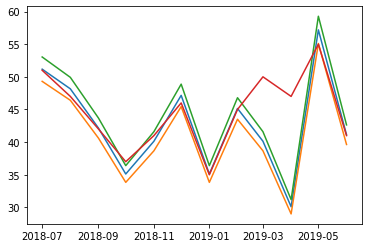

In [281]:
plt.plot(combineCustomers)

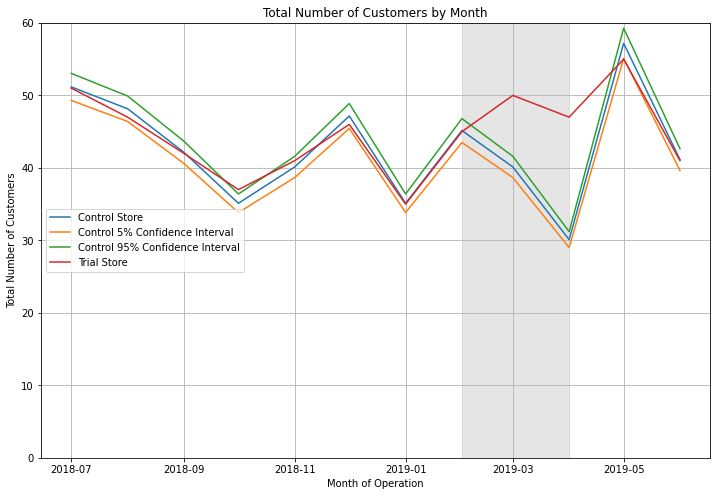

<Figure size 432x288 with 0 Axes>

In [282]:
# Let's embellish the plot

# Make it bigger
plt.figure(figsize = (12, 8))
plt.plot(combineCustomers)

# Set graph title and axis title
plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')

# Set legend
plt.legend(['Control Store', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 6)

# Set new y-axis limit
plt.ylim((0, 60))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()
plt.savefig('Total Number of Customers by Month1.png')

Now we need to repeat the process of finding the control store and assessing the impact of the trial for the two remaining trial stores, 86 and 88.

# Selecting control store for trial 86

In [283]:
# Compute correlation with trial store 86
trial_store = 86
corr_nSales = calculateCorrelation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculateCorrelation(preTrialMeasures, 'nCustomers', trial_store)

# Compute magnitude with trial store 86
magnitude_nSales = calculateMagnitudeDistance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(preTrialMeasures, 'nCustomers', trial_store)

In [284]:
# Concatenate the scores together for 'nSales'

score_nSales = pd.concat([corr_nSales, magnitude_nSales['Magnitude']], axis = 1)

In [285]:
# Add an additional column which calculates the weighted average

corr_weight = 0.5
score_nSales['scoreNSales'] = corr_weight * score_nSales['Correlation'] + (1 - corr_weight) * score_nSales['Magnitude']
score_nSales.head()

,Store1,Store2,Correlation,Magnitude,scoreNSales
0,86.0,1.0,0.445632,0.488334,0.466983
1,86.0,2.0,-0.403835,0.321131,-0.041352
2,86.0,3.0,-0.261284,0.507515,0.123116
3,86.0,4.0,-0.039035,0.635654,0.298309
4,86.0,5.0,0.235159,0.579835,0.407497


In [286]:
# Now do the same for 'nCustomers'

score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['Magnitude']], axis = 1)
score_nCustomers.head()

,Store1,Store2,Correlation,Magnitude
0,86.0,1.0,0.485831,0.510204
1,86.0,2.0,-0.086161,0.428571
2,86.0,3.0,-0.353786,0.563025
3,86.0,4.0,-0.169608,0.537815
4,86.0,5.0,-0.253229,0.714286


In [287]:
# Again add a new column for weighted average

score_nCustomers['scoreNCust'] = corr_weight * score_nCustomers['Correlation'] + (1 - corr_weight) * score_nCustomers['Magnitude']
score_nCustomers.head()

,Store1,Store2,Correlation,Magnitude,scoreNCust
0,86.0,1.0,0.485831,0.510204,0.498018
1,86.0,2.0,-0.086161,0.428571,0.171205
2,86.0,3.0,-0.353786,0.563025,0.104620
3,86.0,4.0,-0.169608,0.537815,0.184103
4,86.0,5.0,-0.253229,0.714286,0.230528


In [288]:
# Index both 'score_nSales' and 'score_nCustomers' dataframe

score_nSales.set_index(['Store1', 'Store2'], inplace = True)
score_nCustomers.set_index(['Store1', 'Store2'], inplace = True)

In [289]:
# Create a new dataframe 'score_Control' which takes the average of 'scoreNSales' and 'scoreNCust'

score_Control = pd.concat([score_nSales['scoreNSales'], score_nCustomers['scoreNCust']], axis = 1)
score_Control

scoreNSales  scoreNCust
Store1 Store2                         
86.0   1.0        0.466983    0.498018
       2.0       -0.041352    0.171205
       3.0        0.123116    0.104620
       4.0        0.298309    0.184103
       5.0        0.407497    0.230528
...                    ...         ...
       268.0     -0.080126    0.266027
       269.0      0.588661    0.241523
       270.0     -0.106832   -0.058237
       271.0      0.546651    0.432804
       272.0      0.294383    0.139863

[260 rows x 2 columns]

In [290]:
# Add a new column to 'score_Control' which computes the average of 'scoreNSales' and 'scoreNCust'

score_Control['finalControlScore'] = 0.5 * (score_Control['scoreNSales'] + score_Control['scoreNCust'])
score_Control.head()

scoreNSales  scoreNCust  finalControlScore
Store1 Store2                                            
86.0   1.0        0.466983    0.498018           0.482500
       2.0       -0.041352    0.171205           0.064927
       3.0        0.123116    0.104620           0.113868
       4.0        0.298309    0.184103           0.241206
       5.0        0.407497    0.230528           0.319013

In [291]:
# Let's see the top 5 stores with highest 'finalControlScore'

score_Control.sort_values(by = 'finalControlScore', ascending = False).head()

# Comment: store 155 matches trial store 86 the most

scoreNSales  scoreNCust  finalControlScore
Store1 Store2                                            
86.0   155.0      0.808106    0.733343           0.770724
       109.0      0.697120    0.742532           0.719826
       114.0      0.631393    0.663384           0.647389
       225.0      0.601841    0.684356           0.643099
       138.0      0.593296    0.660565           0.626930

In [292]:
# Set control store 135 as 'control_store'

control_store = 155

In [293]:
# Create a new dataframe 'pastSales'
pastSales = preTrialMeasures

# Create a new column within 'pastSales' which categorises store type
store_type = []

for i in pastSales['STORE_NBR']:
    if i == trial_store:
        store_type.append('Trial Store')
    elif i == control_store:
        store_type.append('Control Store')
    else:
        store_type.append('Other Stores')

pastSales['store_type'] = store_type
pastSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


In [294]:
# Currently 'YEARMONTH' is an int64 so we need to turn it into a datetime variable to able to plot
# Create a new column 'TransactionMonth'

pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format = '%Y%m')
pastSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


In [295]:
# Now create 'totSales' visualisation for control store, trial store and other stores

# First create relevant dataframes 
controlSalesPlot = pastSales.loc[pastSales['store_type'] == 'Control Store', ['TransactionMonth', 'totSales']]
controlSalesPlot.set_index('TransactionMonth', inplace = True)
controlSalesPlot.rename(columns = {'totSales': 'Control Store'}, inplace = True)
trialSalesPlot = pastSales.loc[pastSales['store_type'] == 'Trial Store', ['TransactionMonth', 'totSales']]
trialSalesPlot.set_index('TransactionMonth', inplace = True)
trialSalesPlot.rename(columns = {'totSales': 'Trial Store'}, inplace = True)
otherSalesPlot = pastSales.loc[pastSales['store_type'] == 'Other Stores', ['TransactionMonth', 'totSales']]
otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('TransactionMonth').totSales.mean())
otherSalesPlot.rename(columns = {'totSales': 'Other Stores'}, inplace = True)

# Concatenate
combineSalesPlot = pd.concat([controlSalesPlot, trialSalesPlot, otherSalesPlot], axis = 1)
combineSalesPlot

,Control Store,Trial Store,Other Stores
TransactionMonth,,,
2018-07-01,924.6,892.20,633.239922
2018-08-01,782.7,764.05,606.326744
2018-09-01,1014.4,914.60,614.480620
2018-10-01,963.8,948.40,629.415504
2018-11-01,898.8,918.00,613.593411
2018-12-01,849.8,841.20,644.020155
2019-01-01,874.6,841.40,623.513566


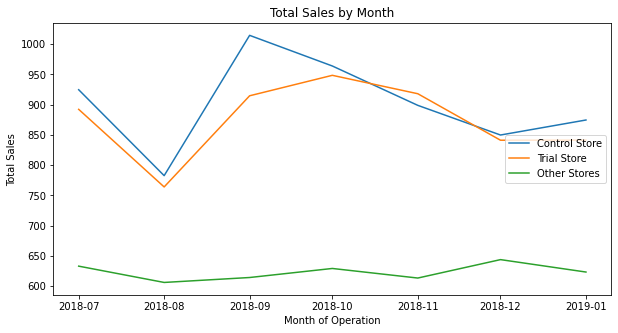

In [296]:
# Plot total sales by month for all 3 types of stores

plt.figure(figsize = (10, 5))
plt.plot(combineSalesPlot)
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 5)

In [297]:
# Do the same for 'nCustomers' 

# First create relevant dataframes 
controlCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Control Store', ['TransactionMonth', 'nCustomers']]
controlCustomersPlot.set_index('TransactionMonth', inplace = True)
controlCustomersPlot.rename(columns = {'nCustomers': 'Control Store'}, inplace = True)
trialCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Trial Store', ['TransactionMonth', 'nCustomers']]
trialCustomersPlot.set_index('TransactionMonth', inplace = True)
trialCustomersPlot.rename(columns = {'nCustomers': 'Trial Store'}, inplace = True)
otherCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Other Stores', ['TransactionMonth', 'nCustomers']]
otherCustomersPlot = pd.DataFrame(otherCustomersPlot.groupby('TransactionMonth').nCustomers.mean())
otherCustomersPlot.rename(columns = {'nCustomers': 'Other Stores'}, inplace = True)

# Concatenate
combineCustomersPlot = pd.concat([controlCustomersPlot, trialCustomersPlot, otherCustomersPlot], axis = 1)
combineCustomersPlot

,Control Store,Trial Store,Other Stores
TransactionMonth,,,
2018-07-01,101,99,71.953488
2018-08-01,91,94,71.771318
2018-09-01,103,103,69.658915
2018-10-01,108,109,71.046512
2018-11-01,101,100,70.069767
2018-12-01,97,98,73.120155
2019-01-01,96,94,70.775194


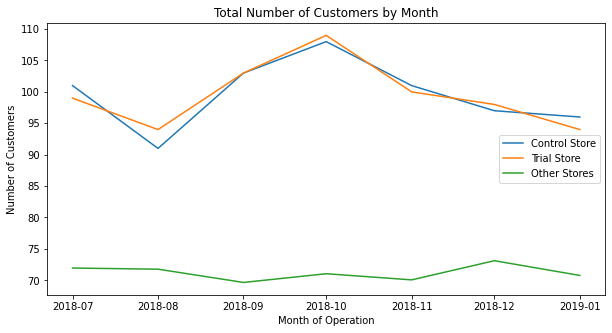

In [298]:
# Plot total number of customers for all 3 types of stores

plt.figure(figsize = (10, 5))
plt.plot(combineCustomersPlot)
plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 5)

# Assessment for trial for trial store 86

In [299]:
# First I worked out a scaling factor to apply to the control store
# I computed this by dividing sum of 'totSales' for trial store by sum of 'totSales' for control store
# Calling this variable 'scalingFactorSales'

trial_sum = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Trial Store' , 'totSales'].sum()
control_sum = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Control Store', 'totSales'].sum()
scalingFactorSales = trial_sum / control_sum
scalingFactorSales

0.9700651481287743

In [300]:
# Create a new dataframe 'scaledControlSales'
# Recall our dataframe before filtering out the trial period is called 'measureOverTime'

measureOverTime.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,2018-11-01


In [301]:
# Create dataframe and reset index

scaledControlSales = measureOverTime
scaledControlSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,2018-11-01


In [302]:
# We only want control store i.e. store 155

scaledControlSales = scaledControlSales.loc[scaledControlSales['STORE_NBR'] == control_store]
scaledControlSales

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
1793,155,201807,924.60,101,1.217822,2.032520,3.698400,2018-07-01
1794,155,201808,782.70,91,1.307692,1.924370,3.417904,2018-08-01
1795,155,201809,1014.40,103,1.398058,2.013889,3.497931,2018-09-01
1796,155,201810,963.80,108,1.259259,2.000000,3.543382,2018-10-01
1797,155,201811,898.80,101,1.316832,2.030075,3.328889,2018-11-01
1798,155,201812,849.80,97,1.237113,2.016667,3.511570,2018-12-01
1799,155,201901,874.60,96,1.302083,2.016000,3.470635,2019-01-01
1800,155,201902,891.20,95,1.315789,2.032000,3.508661,2019-02-01
1801,155,201903,804.40,94,1.255319,2.033898,3.351667,2019-03-01
1802,155,201904,844.60,99,1.212121,2.016667,3.490083,2019-04-01


In [303]:
# Create 'controlSales' which applies 'scalingFactorSales' to 'totSales' column

scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorSales
scaledControlSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlSales
1793,155,201807,924.6,101,1.217822,2.032520,3.698400,2018-07-01,896.922236
1794,155,201808,782.7,91,1.307692,1.924370,3.417904,2018-08-01,759.269991
1795,155,201809,1014.4,103,1.398058,2.013889,3.497931,2018-09-01,984.034086
1796,155,201810,963.8,108,1.259259,2.000000,3.543382,2018-10-01,934.948790
1797,155,201811,898.8,101,1.316832,2.030075,3.328889,2018-11-01,871.894555


In [304]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlSales[['YEARMONTH', 'controlSales']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'totSales'
trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, 'totSales']
trialSales.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialSales], axis = 1)
percentageDiff.rename(columns = {'totSales': 'trialSales'}, inplace = True)

In [305]:
# Calculate percentage difference and put it in a new column

percentageDiff['percentageDiff'] = abs(percentageDiff.controlSales - percentageDiff.trialSales) / percentageDiff.controlSales
percentageDiff

,YEARMONTH,controlSales,trialSales,percentageDiff
0,201807,896.922236,892.20,0.005265
1,201808,759.269991,764.05,0.006296
2,201809,984.034086,914.60,0.070561
3,201810,934.948790,948.40,0.014387
4,201811,871.894555,918.00,0.052880
5,201812,824.361363,841.20,0.020426
6,201901,848.418979,841.40,0.008273
7,201902,864.522060,913.20,0.056306
8,201903,780.320405,1026.80,0.315870
9,201904,819.317024,848.20,0.035253


In [306]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = stdev(percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'])
stdDev

0.025833952854772368

In [307]:
# Recall our 'scaledControlSales' dataframe

scaledControlSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlSales
1793,155,201807,924.6,101,1.217822,2.032520,3.698400,2018-07-01,896.922236
1794,155,201808,782.7,91,1.307692,1.924370,3.417904,2018-08-01,759.269991
1795,155,201809,1014.4,103,1.398058,2.013889,3.497931,2018-09-01,984.034086
1796,155,201810,963.8,108,1.259259,2.000000,3.543382,2018-10-01,934.948790
1797,155,201811,898.8,101,1.316832,2.030075,3.328889,2018-11-01,871.894555


In [308]:
# Add a new column 'TransactionMonth' to 'scaledControlSales'

scaledControlSales['TransactionMonth'] = pd.to_datetime(scaledControlSales['YEARMONTH'].astype(str), format = '%Y%m')
scaledControlSales

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlSales
1793,155,201807,924.60,101,1.217822,2.032520,3.698400,2018-07-01,896.922236
1794,155,201808,782.70,91,1.307692,1.924370,3.417904,2018-08-01,759.269991
1795,155,201809,1014.40,103,1.398058,2.013889,3.497931,2018-09-01,984.034086
1796,155,201810,963.80,108,1.259259,2.000000,3.543382,2018-10-01,934.948790
1797,155,201811,898.80,101,1.316832,2.030075,3.328889,2018-11-01,871.894555
1798,155,201812,849.80,97,1.237113,2.016667,3.511570,2018-12-01,824.361363
1799,155,201901,874.60,96,1.302083,2.016000,3.470635,2019-01-01,848.418979
1800,155,201902,891.20,95,1.315789,2.032000,3.508661,2019-02-01,864.522060
1801,155,201903,804.40,94,1.255319,2.033898,3.351667,2019-03-01,780.320405
1802,155,201904,844.60,99,1.212121,2.016667,3.490083,2019-04-01,819.317024


In [309]:
# Time for some visualisation
# First we need to create the appropriate dataframe
# Extract 'controlSales' from 'scaledControlSales' dataframe for control store 

controlSales = scaledControlSales.loc[:, ['TransactionMonth', 'controlSales']]
controlSales.set_index('TransactionMonth', inplace = True)
controlSales.rename(columns = {'controlSales': 'Control Sales'}, inplace = True)

In [310]:
# Create a new column 'TransationMonth' under 'measureOverTime' dataframe

measureOverTime['TransactionMonth'] = pd.to_datetime(measureOverTime['YEARMONTH'].astype(str), format = '%Y%m')
measureOverTime.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,2018-11-01


In [311]:
# Extract 'totSales' for trial store from 'measureOverTime'

trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, ['TransactionMonth', 'totSales']]
trialSales.set_index('TransactionMonth', inplace = True)
trialSales.rename(columns = {'totSales': 'Trial Sales'}, inplace = True)
trialSales

,Trial Sales
TransactionMonth,
2018-07-01,892.20
2018-08-01,764.05
2018-09-01,914.60
2018-10-01,948.40
2018-11-01,918.00
2018-12-01,841.20
2019-01-01,841.40
2019-02-01,913.20
2019-03-01,1026.80


In [312]:
# Create two new columns under 'controlSales' which calculates the 5% and 95% confidence interval

controlSales['Control 5% Confidence Interval'] = controlSales['Control Sales'] * (1 - stdDev*2)
controlSales['Control 95% Confidence Interval'] = controlSales['Control Sales'] * (1 + stdDev*2)
controlSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval
TransactionMonth,,,
2018-07-01,896.922236,850.580142,943.264329
2018-08-01,759.269991,720.040101,798.499882
2018-09-01,984.034086,933.191106,1034.877067
2018-10-01,934.948790,886.641944,983.255636
2018-11-01,871.894555,826.845589,916.943521
2018-12-01,824.361363,781.768338,866.954388
2019-01-01,848.418979,804.582947,892.255010
2019-02-01,864.522060,819.854016,909.190104
2019-03-01,780.320405,740.002884,820.637926


In [313]:
# Merge the two dataframes together 'controlSales' and 'trialSales'

combineSales = pd.merge(controlSales, trialSales, left_index = True, right_index = True)
combineSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Sales
TransactionMonth,,,,
2018-07-01,896.922236,850.580142,943.264329,892.20
2018-08-01,759.269991,720.040101,798.499882,764.05
2018-09-01,984.034086,933.191106,1034.877067,914.60
2018-10-01,934.948790,886.641944,983.255636,948.40
2018-11-01,871.894555,826.845589,916.943521,918.00
2018-12-01,824.361363,781.768338,866.954388,841.20
2019-01-01,848.418979,804.582947,892.255010,841.40
2019-02-01,864.522060,819.854016,909.190104,913.20
2019-03-01,780.320405,740.002884,820.637926,1026.80


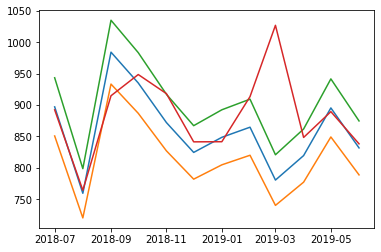

In [314]:
plt.plot(combineSales)

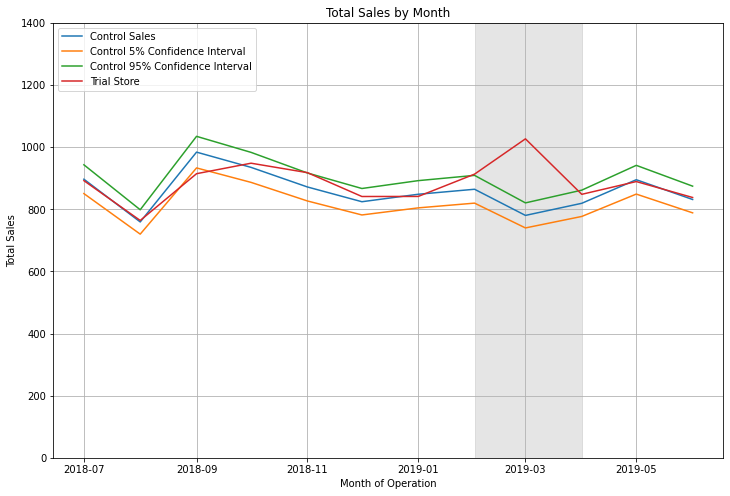

In [315]:
# Let's embellish the plot

# Make it bigger
plt.figure(figsize = (12, 8))
plt.plot(combineSales)

# Set graph title and axis title
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')

# Set legend
plt.legend(['Control Sales', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)

# Set new y-axis limit
plt.ylim((0, 1400))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()


The results show that the trial in store 86 is not significantly different to its control store in the trial period. The trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months.

In [316]:
# Moving on to 'nCustomers'
# First, compute scaling factor
# Then call this variable 'scalingFactorCustomers'

trial_customers = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Trial Store' , 'nCustomers'].sum()
control_customers = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Control Store', 'nCustomers'].sum()
scalingFactorCustomers = trial_customers / control_customers
scalingFactorCustomers

1.0

In [317]:
scaledControlCustomers = measureOverTime
scaledControlCustomers.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,2018-11-01


In [318]:
scaledControlCustomers = scaledControlCustomers.loc[scaledControlCustomers['STORE_NBR'] == control_store]
scaledControlCustomers.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
1793,155,201807,924.6,101,1.217822,2.032520,3.698400,2018-07-01
1794,155,201808,782.7,91,1.307692,1.924370,3.417904,2018-08-01
1795,155,201809,1014.4,103,1.398058,2.013889,3.497931,2018-09-01
1796,155,201810,963.8,108,1.259259,2.000000,3.543382,2018-10-01
1797,155,201811,898.8,101,1.316832,2.030075,3.328889,2018-11-01


In [319]:
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorCustomers
scaledControlCustomers.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlCustomers
1793,155,201807,924.6,101,1.217822,2.032520,3.698400,2018-07-01,101.0
1794,155,201808,782.7,91,1.307692,1.924370,3.417904,2018-08-01,91.0
1795,155,201809,1014.4,103,1.398058,2.013889,3.497931,2018-09-01,103.0
1796,155,201810,963.8,108,1.259259,2.000000,3.543382,2018-10-01,108.0
1797,155,201811,898.8,101,1.316832,2.030075,3.328889,2018-11-01,101.0


In [320]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlCustomers[['YEARMONTH', 'controlCustomers']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'nCustomers'
trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, 'nCustomers']
trialCustomers.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialCustomers], axis = 1)
percentageDiff.rename(columns = {'nCustomers': 'trialCustomers'}, inplace = True)

percentageDiff

,YEARMONTH,controlCustomers,trialCustomers
0,201807,101.0,99
1,201808,91.0,94
2,201809,103.0,103
3,201810,108.0,109
4,201811,101.0,100
5,201812,97.0,98
6,201901,96.0,94
7,201902,95.0,107
8,201903,94.0,115
9,201904,99.0,105


In [321]:
# Calculate percentage difference and put it in a new column

percentageDiff['percentageDiff'] = abs(percentageDiff.controlCustomers - percentageDiff.trialCustomers) / percentageDiff.controlCustomers
percentageDiff

,YEARMONTH,controlCustomers,trialCustomers,percentageDiff
0,201807,101.0,99,0.019802
1,201808,91.0,94,0.032967
2,201809,103.0,103,0.000000
3,201810,108.0,109,0.009259
4,201811,101.0,100,0.009901
5,201812,97.0,98,0.010309
6,201901,96.0,94,0.020833
7,201902,95.0,107,0.126316
8,201903,94.0,115,0.223404
9,201904,99.0,105,0.060606


In [322]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = stdev(percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'])
stdDev

0.010687444701395236

In [323]:
# Define the degrees of freedom
# Since we have 8 pre-trial months, dof = 8 - 1 = 7

dof = 7

In [324]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905), 'tValue']

7    11.819082
8    20.903430
9     5.670772
Name: tValue, dtype: float64

In [325]:
# Find the 95th percentile of the t distribution with dof = 7

t.isf(0.05, dof)

# Comment: We can see that the t-value is larger than the 95th percentile value of the t-distribution 

1.8945786050613054

In [326]:
# Time for some visualisation
# First we need to create the appropriate dataframe
# Extract 'controlCustomers' from 'scaledControlCustomers' dataframe for control store 

controlCustomers = scaledControlCustomers.loc[:, ['TransactionMonth', 'controlCustomers']]
controlCustomers.set_index('TransactionMonth', inplace = True)
controlCustomers.rename(columns = {'controlCustomers': 'Control Customers'}, inplace = True)
controlCustomers

,Control Customers
TransactionMonth,
2018-07-01,101.0
2018-08-01,91.0
2018-09-01,103.0
2018-10-01,108.0
2018-11-01,101.0
2018-12-01,97.0
2019-01-01,96.0
2019-02-01,95.0
2019-03-01,94.0


In [327]:
# Extract 'nCustomers' for trial store from 'measureOverTime'

trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, ['TransactionMonth', 'nCustomers']]
trialCustomers.set_index('TransactionMonth', inplace = True)
trialCustomers.rename(columns = {'nCustomers': 'Trial Customers'}, inplace = True)
trialCustomers

,Trial Customers
TransactionMonth,
2018-07-01,99
2018-08-01,94
2018-09-01,103
2018-10-01,109
2018-11-01,100
2018-12-01,98
2019-01-01,94
2019-02-01,107
2019-03-01,115


In [328]:
# Create two new columns under 'controlCustomers' which calculates the 5% and 95% confidence interval

controlCustomers['Control 5% Confidence Interval'] = controlCustomers['Control Customers'] * (1 - stdDev*2)
controlCustomers['Control 95% Confidence Interval'] = controlCustomers['Control Customers'] * (1 + stdDev*2)
controlCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval
TransactionMonth,,,
2018-07-01,101.0,98.841136,103.158864
2018-08-01,91.0,89.054885,92.945115
2018-09-01,103.0,100.798386,105.201614
2018-10-01,108.0,105.691512,110.308488
2018-11-01,101.0,98.841136,103.158864
2018-12-01,97.0,94.926636,99.073364
2019-01-01,96.0,93.948011,98.051989
2019-02-01,95.0,92.969386,97.030614
2019-03-01,94.0,91.990760,96.009240


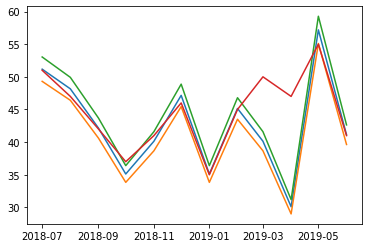

In [329]:
plt.plot(combineCustomers)

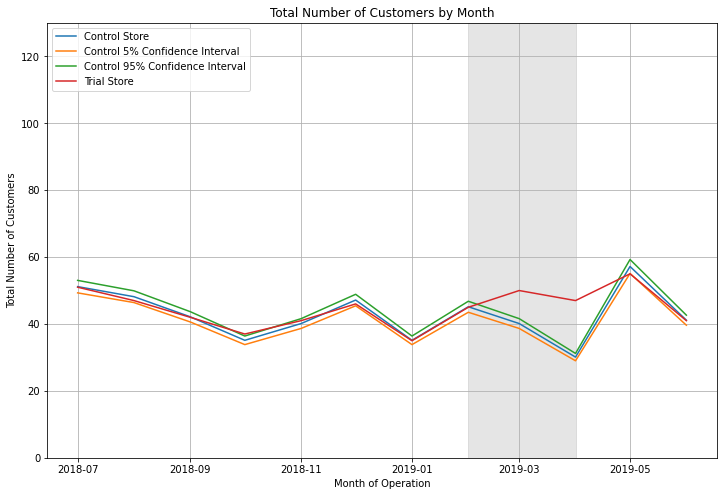

<Figure size 432x288 with 0 Axes>

In [330]:
# Let's embellish the plot

# Make it bigger
plt.figure(figsize = (12, 8))
plt.plot(combineCustomers)

# Set graph title and axis title
plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')

# Set legend
plt.legend(['Control Store', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)

# Set new y-axis limit
plt.ylim((0, 130))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()
plt.savefig('Total Number of Customers by Month2.png')

It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but as we saw, sales were not significantly higher. We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.

# Selecting control store for trial store 88

In [331]:
# Now let's use those two functions to find the control store

# Compute correlation with trial store 88
trial_store = 88
corr_nSales = calculateCorrelation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculateCorrelation(preTrialMeasures, 'nCustomers', trial_store)

# Compute magnitude with trial store 88
magnitude_nSales = calculateMagnitudeDistance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(preTrialMeasures, 'nCustomers', trial_store)


In [332]:
# Let's see what they look like

corr_nSales.head()

,Store1,Store2,Correlation
0,88.0,1.0,0.813636
1,88.0,2.0,-0.067927
2,88.0,3.0,-0.507847
3,88.0,4.0,-0.745566
4,88.0,5.0,0.190330


In [333]:
magnitude_nSales

,Store1,Store2,Magnitude
0,88.0,1.0,0.548959
1,88.0,2.0,0.541212
2,88.0,3.0,0.458109
3,88.0,4.0,0.484447
4,88.0,5.0,0.496409
...,...,...,...
255,88.0,268.0,0.522847
256,88.0,269.0,0.564856
257,88.0,270.0,0.513329
258,88.0,271.0,0.429220


In [334]:
# Concatenate the scores together for 'nSales'

score_nSales = pd.concat([corr_nSales, magnitude_nSales['Magnitude']], axis = 1)

In [335]:
# Add an additional column which calculates the weighted average

corr_weight = 0.5
score_nSales['scoreNSales'] = corr_weight * score_nSales['Correlation'] + (1 - corr_weight) * score_nSales['Magnitude']
score_nSales.head()

,Store1,Store2,Correlation,Magnitude,scoreNSales
0,88.0,1.0,0.813636,0.548959,0.681297
1,88.0,2.0,-0.067927,0.541212,0.236643
2,88.0,3.0,-0.507847,0.458109,-0.024869
3,88.0,4.0,-0.745566,0.484447,-0.130559
4,88.0,5.0,0.190330,0.496409,0.343370


In [336]:
# Now do the same for 'nCustomers'

score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['Magnitude']], axis = 1)
score_nCustomers.head()

,Store1,Store2,Correlation,Magnitude
0,88.0,1.0,0.305334,0.357143
1,88.0,2.0,-0.452379,0.285714
2,88.0,3.0,0.522884,0.683673
3,88.0,4.0,-0.361503,0.577922
4,88.0,5.0,-0.025320,0.558442


In [337]:
# Again add a new column for weighted average

score_nCustomers['scoreNCust'] = corr_weight * score_nCustomers['Correlation'] + (1 - corr_weight) * score_nCustomers['Magnitude']
score_nCustomers.head()

,Store1,Store2,Correlation,Magnitude,scoreNCust
0,88.0,1.0,0.305334,0.357143,0.331238
1,88.0,2.0,-0.452379,0.285714,-0.083332
2,88.0,3.0,0.522884,0.683673,0.603279
3,88.0,4.0,-0.361503,0.577922,0.108210
4,88.0,5.0,-0.025320,0.558442,0.266561


In [338]:
# Index both 'score_nSales' and 'score_nCustomers' dataframe

score_nSales.set_index(['Store1', 'Store2'], inplace = True)
score_nCustomers.set_index(['Store1', 'Store2'], inplace = True)

In [339]:
# Create a new dataframe 'score_Control' which takes the average of 'scoreNSales' and 'scoreNCust'

score_Control = pd.concat([score_nSales['scoreNSales'], score_nCustomers['scoreNCust']], axis = 1)
score_Control

scoreNSales  scoreNCust
Store1 Store2                         
88.0   1.0        0.681297    0.331238
       2.0        0.236643   -0.083332
       3.0       -0.024869    0.603279
       4.0       -0.130559    0.108210
       5.0        0.343370    0.266561
...                    ...         ...
       268.0      0.250709    0.651462
       269.0      0.196139    0.043061
       270.0     -0.104971    0.132467
       271.0      0.163091    0.318507
       272.0     -0.077482    0.237944

[260 rows x 2 columns]

In [340]:
# Add a new column to 'score_Control' which computes the average of 'scoreNSales' and 'scoreNCust'

score_Control['finalControlScore'] = 0.5 * (score_Control['scoreNSales'] + score_Control['scoreNCust'])
score_Control.head()

scoreNSales  scoreNCust  finalControlScore
Store1 Store2                                            
88.0   1.0        0.681297    0.331238           0.506268
       2.0        0.236643   -0.083332           0.076655
       3.0       -0.024869    0.603279           0.289205
       4.0       -0.130559    0.108210          -0.011175
       5.0        0.343370    0.266561           0.304965

In [341]:
# Let's see the top 5 stores with highest 'finalControlScore'

score_Control.sort_values(by = 'finalControlScore', ascending = False).head()

scoreNSales  scoreNCust  finalControlScore
Store1 Store2                                            
88.0   178.0      0.650803    0.707828           0.679316
       14.0       0.646064    0.685774           0.665919
       134.0      0.775084    0.540154           0.657619
       237.0      0.451974    0.777235           0.614604
       187.0      0.616752    0.594560           0.605656

In [342]:
# After doing some visualisations, found that stores 178, 14 and 134 do not match trial store so set store 237 as control store

control_store = 237

In [343]:
# Create a new dataframe 'pastSales'
pastSales = preTrialMeasures

# Create a new column within 'pastSales' which categorises store type
store_type = []

for i in pastSales['STORE_NBR']:
    if i == trial_store:
        store_type.append('Trial Store')
    elif i == control_store:
        store_type.append('Control Store')
    else:
        store_type.append('Other Stores')

pastSales['store_type'] = store_type
pastSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


In [344]:
# Currently 'YEARMONTH' is an int64 so we need to turn it into a datetime variable to able to plot
# Create a new column 'TransactionMonth'

pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format = '%Y%m')
pastSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


In [345]:
# Now create 'totSales' visualisation for control store, trial store and other stores

# First create relevant dataframes 
controlSalesPlot = pastSales.loc[pastSales['store_type'] == 'Control Store', ['TransactionMonth', 'totSales']]
controlSalesPlot.set_index('TransactionMonth', inplace = True)
controlSalesPlot.rename(columns = {'totSales': 'Control Store'}, inplace = True)
trialSalesPlot = pastSales.loc[pastSales['store_type'] == 'Trial Store', ['TransactionMonth', 'totSales']]
trialSalesPlot.set_index('TransactionMonth', inplace = True)
trialSalesPlot.rename(columns = {'totSales': 'Trial Store'}, inplace = True)
otherSalesPlot = pastSales.loc[pastSales['store_type'] == 'Other Stores', ['TransactionMonth', 'totSales']]
otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('TransactionMonth').totSales.mean())
otherSalesPlot.rename(columns = {'totSales': 'Other Stores'}, inplace = True)

# Concatenate
combineSalesPlot = pd.concat([controlSalesPlot, trialSalesPlot, otherSalesPlot], axis = 1)
combineSalesPlot

,Control Store,Trial Store,Other Stores
TransactionMonth,,,
2018-07-01,1448.4,1310.0,629.590310
2018-08-01,1367.8,1323.8,601.889341
2018-09-01,1322.2,1423.0,611.317054
2018-10-01,1348.3,1352.4,626.359302
2018-11-01,1397.6,1382.8,609.858527
2018-12-01,1265.0,1325.2,640.534884
2019-01-01,1219.7,1266.4,620.528682


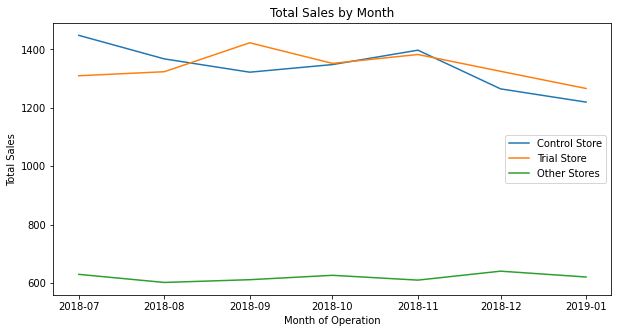

In [346]:
# Plot total sales by month for all 3 types of stores

plt.figure(figsize = (10, 5))
plt.plot(combineSalesPlot)
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 5)

In [347]:
# Do the same for 'nCustomers' 

# First create relevant dataframes 
controlCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Control Store', ['TransactionMonth', 'nCustomers']]
controlCustomersPlot.set_index('TransactionMonth', inplace = True)
controlCustomersPlot.rename(columns = {'nCustomers': 'Control Store'}, inplace = True)
trialCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Trial Store', ['TransactionMonth', 'nCustomers']]
trialCustomersPlot.set_index('TransactionMonth', inplace = True)
trialCustomersPlot.rename(columns = {'nCustomers': 'Trial Store'}, inplace = True)
otherCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Other Stores', ['TransactionMonth', 'nCustomers']]
otherCustomersPlot = pd.DataFrame(otherCustomersPlot.groupby('TransactionMonth').nCustomers.mean())
otherCustomersPlot.rename(columns = {'nCustomers': 'Other Stores'}, inplace = True)

# Concatenate
combineCustomersPlot = pd.concat([controlCustomersPlot, trialCustomersPlot, otherCustomersPlot], axis = 1)
combineCustomersPlot

,Control Store,Trial Store,Other Stores
TransactionMonth,,,
2018-07-01,128,129,71.732558
2018-08-01,135,131,71.457364
2018-09-01,126,124,69.488372
2018-10-01,123,123,70.934109
2018-11-01,132,130,69.833333
2018-12-01,124,126,72.906977
2019-01-01,117,117,70.604651


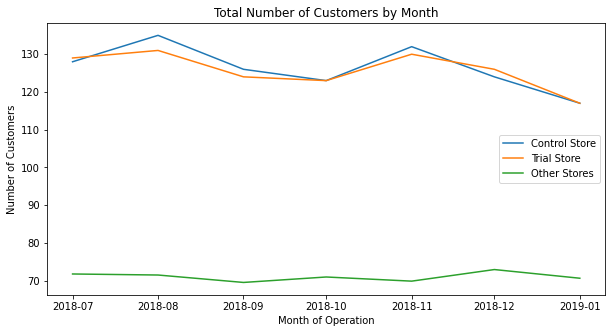

In [348]:
# Plot total number of customers for all 3 types of stores

plt.figure(figsize = (10, 5))
plt.plot(combineCustomersPlot)
plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 5)

# Assessment of trial for trial strore 88

The trial period goes from the start of February 2019 to end of April 2019. We now want to see if there has been an uplift in overall chip sales. 

In [349]:
# First we need to work out a scaling factor to applied to the control store
# We compute this by dividing sum of 'totSales' for trial store by sum of 'totSales' for control store
# Let's call this variable 'scalingFactorSales'

trial_sum = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Trial Store' , 'totSales'].sum()
control_sum = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Control Store', 'totSales'].sum()
scalingFactorSales = trial_sum / control_sum
scalingFactorSales

1.001558330664959

In [350]:
# Create a new dataframe 'scaledControlSales'
# Recall our dataframe before filtering out the trial period is called 'measureOverTime'

measureOverTime.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,2018-11-01


In [351]:
# Create dataframe and reset index

scaledControlSales = measureOverTime
scaledControlSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,2018-11-01


In [352]:
# We only want control store i.e. store 237

scaledControlSales = scaledControlSales.loc[scaledControlSales['STORE_NBR'] == control_store]
scaledControlSales

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
2747,237,201807,1448.4,128,1.265625,2.000000,4.470370,2018-07-01
2748,237,201808,1367.8,135,1.222222,1.896970,4.369968,2018-08-01
2749,237,201809,1322.2,126,1.182540,2.006711,4.422074,2018-09-01
2750,237,201810,1348.3,123,1.195122,2.034014,4.509365,2018-10-01
2751,237,201811,1397.6,132,1.219697,1.987578,4.367500,2018-11-01
2752,237,201812,1265.0,124,1.161290,2.006944,4.377163,2018-12-01
2753,237,201901,1219.7,117,1.188034,1.992806,4.403249,2019-01-01
2754,237,201902,1404.8,126,1.246032,2.000000,4.473885,2019-02-01
2755,237,201903,1208.2,119,1.126050,2.044776,4.409489,2019-03-01
2756,237,201904,1204.6,120,1.125000,2.014815,4.428676,2019-04-01


In [353]:
# Create 'controlSales' which applies 'scalingFactorSales' to 'totSales' column

scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorSales
scaledControlSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlSales
2747,237,201807,1448.4,128,1.265625,2.000000,4.470370,2018-07-01,1450.657086
2748,237,201808,1367.8,135,1.222222,1.896970,4.369968,2018-08-01,1369.931485
2749,237,201809,1322.2,126,1.182540,2.006711,4.422074,2018-09-01,1324.260425
2750,237,201810,1348.3,123,1.195122,2.034014,4.509365,2018-10-01,1350.401097
2751,237,201811,1397.6,132,1.219697,1.987578,4.367500,2018-11-01,1399.777923


In [354]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlSales[['YEARMONTH', 'controlSales']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'totSales'
trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, 'totSales']
trialSales.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialSales], axis = 1)
percentageDiff.rename(columns = {'totSales': 'trialSales'}, inplace = True)

percentageDiff

,YEARMONTH,controlSales,trialSales
0,201807,1450.657086,1310.00
1,201808,1369.931485,1323.80
2,201809,1324.260425,1423.00
3,201810,1350.401097,1352.40
4,201811,1399.777923,1382.80
5,201812,1266.971288,1325.20
6,201901,1221.600696,1266.40
7,201902,1406.989143,1370.20
8,201903,1210.082775,1477.20
9,201904,1206.477165,1439.40


In [355]:
# Calculate percentage difference and put it in a new column

percentageDiff['percentageDiff'] = abs(percentageDiff.controlSales - percentageDiff.trialSales) / percentageDiff.controlSales
percentageDiff

,YEARMONTH,controlSales,trialSales,percentageDiff
0,201807,1450.657086,1310.00,0.096961
1,201808,1369.931485,1323.80,0.033674
2,201809,1324.260425,1423.00,0.074562
3,201810,1350.401097,1352.40,0.001480
4,201811,1399.777923,1382.80,0.012129
5,201812,1266.971288,1325.20,0.045959
6,201901,1221.600696,1266.40,0.036673
7,201902,1406.989143,1370.20,0.026147
8,201903,1210.082775,1477.20,0.220743
9,201904,1206.477165,1439.40,0.193060


In [356]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = stdev(percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'])
stdDev

0.0334678673030788

In [357]:
# Define the degrees of freedom
# Since we have 8 pre-trial months, dof = 8 - 1 = 7

dof = 7

In [358]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905), 'tValue']

7    0.781270
8    6.595668
9    5.768527
Name: tValue, dtype: float64

In [359]:
# Find the 95th percentile of the t distribution with dof = 7

t.isf(0.05, dof)

1.8945786050613054

In [360]:
# Recall  'scaledControlSales' dataframe

scaledControlSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlSales
2747,237,201807,1448.4,128,1.265625,2.000000,4.470370,2018-07-01,1450.657086
2748,237,201808,1367.8,135,1.222222,1.896970,4.369968,2018-08-01,1369.931485
2749,237,201809,1322.2,126,1.182540,2.006711,4.422074,2018-09-01,1324.260425
2750,237,201810,1348.3,123,1.195122,2.034014,4.509365,2018-10-01,1350.401097
2751,237,201811,1397.6,132,1.219697,1.987578,4.367500,2018-11-01,1399.777923


In [361]:
# Add a new column 'TransactionMonth' to 'scaledControlSales'

scaledControlSales['TransactionMonth'] = pd.to_datetime(scaledControlSales['YEARMONTH'].astype(str), format = '%Y%m')
scaledControlSales

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlSales
2747,237,201807,1448.4,128,1.265625,2.000000,4.470370,2018-07-01,1450.657086
2748,237,201808,1367.8,135,1.222222,1.896970,4.369968,2018-08-01,1369.931485
2749,237,201809,1322.2,126,1.182540,2.006711,4.422074,2018-09-01,1324.260425
2750,237,201810,1348.3,123,1.195122,2.034014,4.509365,2018-10-01,1350.401097
2751,237,201811,1397.6,132,1.219697,1.987578,4.367500,2018-11-01,1399.777923
2752,237,201812,1265.0,124,1.161290,2.006944,4.377163,2018-12-01,1266.971288
2753,237,201901,1219.7,117,1.188034,1.992806,4.403249,2019-01-01,1221.600696
2754,237,201902,1404.8,126,1.246032,2.000000,4.473885,2019-02-01,1406.989143
2755,237,201903,1208.2,119,1.126050,2.044776,4.409489,2019-03-01,1210.082775
2756,237,201904,1204.6,120,1.125000,2.014815,4.428676,2019-04-01,1206.477165


In [362]:
# Time for some visualisation
# First we need to create the appropriate dataframe
# Extract 'controlSales' from 'scaledControlSales' dataframe for control store 

controlSales = scaledControlSales.loc[:, ['TransactionMonth', 'controlSales']]
controlSales.set_index('TransactionMonth', inplace = True)
controlSales.rename(columns = {'controlSales': 'Control Sales'}, inplace = True)
controlSales

,Control Sales
TransactionMonth,
2018-07-01,1450.657086
2018-08-01,1369.931485
2018-09-01,1324.260425
2018-10-01,1350.401097
2018-11-01,1399.777923
2018-12-01,1266.971288
2019-01-01,1221.600696
2019-02-01,1406.989143
2019-03-01,1210.082775


In [363]:
# Recall 'measureOverTime' dataframe

measureOverTime.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,2018-11-01


In [364]:
# Create a new column 'TransationMonth' under 'measureOverTime' dataframe

measureOverTime['TransactionMonth'] = pd.to_datetime(measureOverTime['YEARMONTH'].astype(str), format = '%Y%m')
measureOverTime.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,2018-11-01


In [365]:
# Extract 'totSales' for trial store from 'measureOverTime'

trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, ['TransactionMonth', 'totSales']]
trialSales.set_index('TransactionMonth', inplace = True)
trialSales.rename(columns = {'totSales': 'Trial Sales'}, inplace = True)
trialSales

,Trial Sales
TransactionMonth,
2018-07-01,1310.00
2018-08-01,1323.80
2018-09-01,1423.00
2018-10-01,1352.40
2018-11-01,1382.80
2018-12-01,1325.20
2019-01-01,1266.40
2019-02-01,1370.20
2019-03-01,1477.20


In [366]:
# Create two new columns under 'controlSales' which calculates the 5% and 95% confidence interval

controlSales['Control 5% Confidence Interval'] = controlSales['Control Sales'] * (1 - stdDev*2)
controlSales['Control 95% Confidence Interval'] = controlSales['Control Sales'] * (1 + stdDev*2)
controlSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval
TransactionMonth,,,
2018-07-01,1450.657086,1353.556288,1547.757884
2018-08-01,1369.931485,1278.234114,1461.628855
2018-09-01,1324.260425,1235.620080,1412.900769
2018-10-01,1350.401097,1260.011008,1440.791187
2018-11-01,1399.777923,1306.082759,1493.473086
2018-12-01,1266.971288,1182.165634,1351.776942
2019-01-01,1221.600696,1139.831956,1303.369436
2019-02-01,1406.989143,1312.811291,1501.166995
2019-03-01,1210.082775,1129.084996,1291.080555


In [367]:
# Merge the two dataframes together 'controlSales' and 'trialSales'

combineSales = pd.merge(controlSales, trialSales, left_index = True, right_index = True)
combineSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Sales
TransactionMonth,,,,
2018-07-01,1450.657086,1353.556288,1547.757884,1310.00
2018-08-01,1369.931485,1278.234114,1461.628855,1323.80
2018-09-01,1324.260425,1235.620080,1412.900769,1423.00
2018-10-01,1350.401097,1260.011008,1440.791187,1352.40
2018-11-01,1399.777923,1306.082759,1493.473086,1382.80
2018-12-01,1266.971288,1182.165634,1351.776942,1325.20
2019-01-01,1221.600696,1139.831956,1303.369436,1266.40
2019-02-01,1406.989143,1312.811291,1501.166995,1370.20
2019-03-01,1210.082775,1129.084996,1291.080555,1477.20


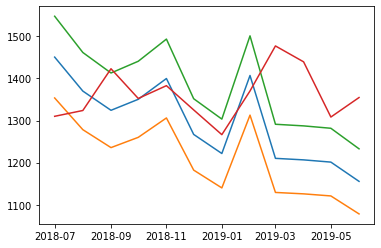

In [368]:
plt.plot(combineSales)

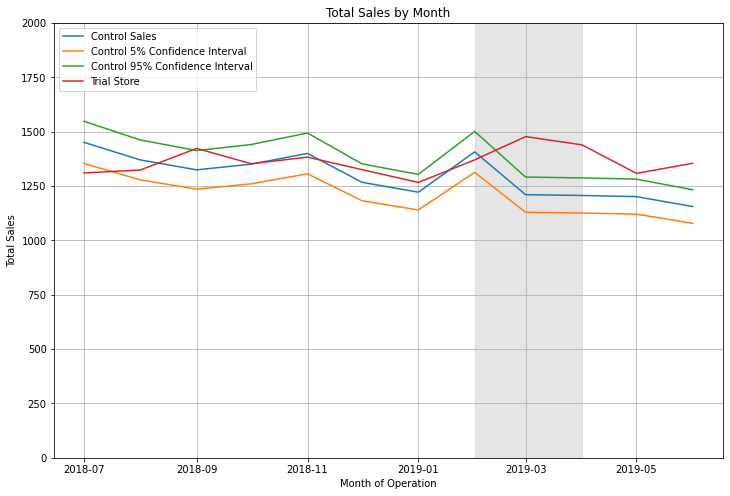

In [369]:
# Let's embellish the plot

# Make it bigger
plt.figure(figsize = (12, 8))
plt.plot(combineSales)

# Set graph title and axis title
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')

# Set legend
plt.legend(['Control Sales', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)

# Set new y-axis limit
plt.ylim((0, 2000))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()


The results show that the trial in store 88 is significantly different to its control store in the trial period. The trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

In [370]:
# Moving on to 'nCustomers'
# First, compute scaling factor
# Then call this variable 'scalingFactorCustomers'

trial_customers = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Trial Store' , 'nCustomers'].sum()
control_customers = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Control Store', 'nCustomers'].sum()
scalingFactorCustomers = trial_customers / control_customers
scalingFactorCustomers


0.9943502824858758

In [371]:
scaledControlCustomers = measureOverTime
scaledControlCustomers.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,2018-11-01


In [372]:
scaledControlCustomers = scaledControlCustomers.loc[scaledControlCustomers['STORE_NBR'] == control_store]
scaledControlCustomers.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
2747,237,201807,1448.4,128,1.265625,2.000000,4.470370,2018-07-01
2748,237,201808,1367.8,135,1.222222,1.896970,4.369968,2018-08-01
2749,237,201809,1322.2,126,1.182540,2.006711,4.422074,2018-09-01
2750,237,201810,1348.3,123,1.195122,2.034014,4.509365,2018-10-01
2751,237,201811,1397.6,132,1.219697,1.987578,4.367500,2018-11-01


In [373]:
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorCustomers
scaledControlCustomers.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlCustomers
2747,237,201807,1448.4,128,1.265625,2.000000,4.470370,2018-07-01,127.276836
2748,237,201808,1367.8,135,1.222222,1.896970,4.369968,2018-08-01,134.237288
2749,237,201809,1322.2,126,1.182540,2.006711,4.422074,2018-09-01,125.288136
2750,237,201810,1348.3,123,1.195122,2.034014,4.509365,2018-10-01,122.305085
2751,237,201811,1397.6,132,1.219697,1.987578,4.367500,2018-11-01,131.254237


In [374]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlCustomers[['YEARMONTH', 'controlCustomers']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'nCustomers'
trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, 'nCustomers']
trialCustomers.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialCustomers], axis = 1)
percentageDiff.rename(columns = {'nCustomers': 'trialCustomers'}, inplace = True)

percentageDiff

,YEARMONTH,controlCustomers,trialCustomers
0,201807,127.276836,129
1,201808,134.237288,131
2,201809,125.288136,124
3,201810,122.305085,123
4,201811,131.254237,130
5,201812,123.299435,126
6,201901,116.338983,117
7,201902,125.288136,124
8,201903,118.327684,134
9,201904,119.322034,128


In [375]:
# Calculate percentage difference and put it in a new column

percentageDiff['percentageDiff'] = abs(percentageDiff.controlCustomers - percentageDiff.trialCustomers) / percentageDiff.controlCustomers
percentageDiff

,YEARMONTH,controlCustomers,trialCustomers,percentageDiff
0,201807,127.276836,129,0.013539
1,201808,134.237288,131,0.024116
2,201809,125.288136,124,0.010281
3,201810,122.305085,123,0.005682
4,201811,131.254237,130,0.009556
5,201812,123.299435,126,0.021902
6,201901,116.338983,117,0.005682
7,201902,125.288136,124,0.010281
8,201903,118.327684,134,0.132448
9,201904,119.322034,128,0.072727


In [376]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = stdev(percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'])
stdDev

0.00741024435207507

In [377]:
# Define the degrees of freedom
# Since we have 8 pre-trial months, dof = 8 - 1 = 7

dof = 7

In [378]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905), 'tValue']

7     1.387456
8    17.873693
9     9.814423
Name: tValue, dtype: float64

In [379]:
# Find the 95th percentile of the t distribution with dof = 7

t.isf(0.05, dof)

# Comment: We can see that the t-value is larger than the 95th percentile value of the t-distribution 

1.8945786050613054

In [380]:
# Time for some visualisation
# First we need to create the appropriate dataframe
# Extract 'controlCustomers' from 'scaledControlCustomers' dataframe for control store 

controlCustomers = scaledControlCustomers.loc[:, ['TransactionMonth', 'controlCustomers']]
controlCustomers.set_index('TransactionMonth', inplace = True)
controlCustomers.rename(columns = {'controlCustomers': 'Control Customers'}, inplace = True)
controlCustomers

,Control Customers
TransactionMonth,
2018-07-01,127.276836
2018-08-01,134.237288
2018-09-01,125.288136
2018-10-01,122.305085
2018-11-01,131.254237
2018-12-01,123.299435
2019-01-01,116.338983
2019-02-01,125.288136
2019-03-01,118.327684


In [381]:
# Extract 'nCustomers' for trial store from 'measureOverTime'

trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, ['TransactionMonth', 'nCustomers']]
trialCustomers.set_index('TransactionMonth', inplace = True)
trialCustomers.rename(columns = {'nCustomers': 'Trial Customers'}, inplace = True)
trialCustomers

,Trial Customers
TransactionMonth,
2018-07-01,129
2018-08-01,131
2018-09-01,124
2018-10-01,123
2018-11-01,130
2018-12-01,126
2019-01-01,117
2019-02-01,124
2019-03-01,134


In [382]:
# Create two new columns under 'controlCustomers' which calculates the 5% and 95% confidence interval

controlCustomers['Control 5% Confidence Interval'] = controlCustomers['Control Customers'] * (1 - stdDev*2)
controlCustomers['Control 95% Confidence Interval'] = controlCustomers['Control Customers'] * (1 + stdDev*2)
controlCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval
TransactionMonth,,,
2018-07-01,127.276836,125.390531,129.163141
2018-08-01,134.237288,132.247826,136.226750
2018-09-01,125.288136,123.431304,127.144967
2018-10-01,122.305085,120.492464,124.117706
2018-11-01,131.254237,129.308985,133.199489
2018-12-01,123.299435,121.472077,125.126793
2019-01-01,116.338983,114.614782,118.063184
2019-02-01,125.288136,123.431304,127.144967
2019-03-01,118.327684,116.574010,120.081358


In [383]:
# Merge the two dataframes together 'controlSales' and 'trialSales'

combineCustomers = pd.merge(controlCustomers, trialCustomers, left_index = True, right_index = True)
combineCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Customers
TransactionMonth,,,,
2018-07-01,127.276836,125.390531,129.163141,129
2018-08-01,134.237288,132.247826,136.226750,131
2018-09-01,125.288136,123.431304,127.144967,124
2018-10-01,122.305085,120.492464,124.117706,123
2018-11-01,131.254237,129.308985,133.199489,130
2018-12-01,123.299435,121.472077,125.126793,126
2019-01-01,116.338983,114.614782,118.063184,117
2019-02-01,125.288136,123.431304,127.144967,124
2019-03-01,118.327684,116.574010,120.081358,134


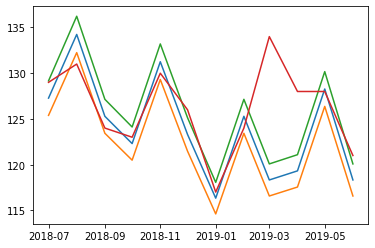

In [384]:
plt.plot(combineCustomers)

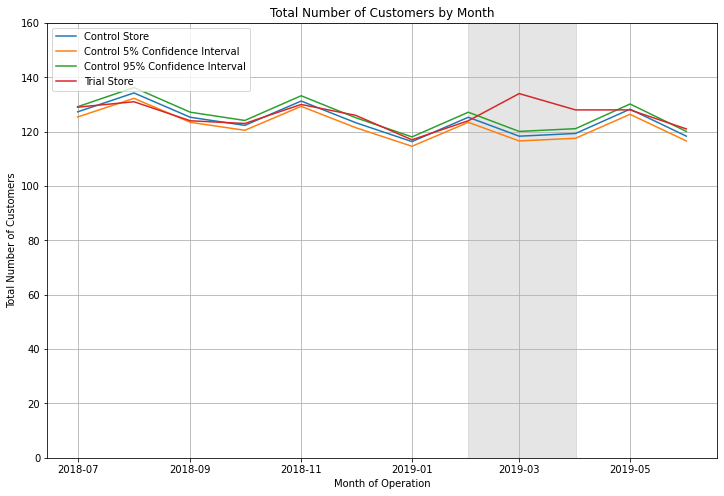

<Figure size 432x288 with 0 Axes>

In [385]:
# Let's embellish the plot

# Make it bigger
plt.figure(figsize = (12, 8))
plt.plot(combineCustomers)

# Set graph title and axis title
plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')

# Set legend
plt.legend(['Control Store', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)

# Set new y-axis limit
plt.ylim((0, 160))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()
plt.savefig('Total Number of Customers by Month3.png')


Total number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months, which indicates a positive trial effect.

# Conclusion for Module 2

It looks like the number of customers is significantly higher in all of the three months. This seems to
suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but
as we saw, sales were not significantly higher. We should check with the Category Manager if there were
special deals in the trial store that were may have resulted in lower prices, impacting the results.